# **Project 2: Network Intrusion Detection System**<a href="#Project-2:-Network-Intrusion-Detection-System" class="anchor-link">¶</a>

##### *Tran Ngoc Bao Huynh and Ong Thao*<a href="#Tran-Ngoc-Bao-Huynh-and-Ong-Thao" class="anchor-link">¶</a>

### **Helpful Tensorflow Functions (Given):**<a href="#Helpful-Tensorflow-Functions-(Given):" class="anchor-link">¶</a>

In \[1\]:

    from collections.abc import Sequence
    from sklearn import preprocessing
    from sklearn import metrics

    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import shutil
    import os
    import time

    from sklearn import metrics
    from tensorflow.keras.models import Sequential, load_model
    from tensorflow.keras.layers import Dense, Activation,Dropout, Flatten
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.callbacks import ModelCheckpoint
    from tensorflow.keras.layers import Conv2D, MaxPooling2D
    from tensorflow.keras import optimizers

    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.linear_model import Lasso

    # Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
    def encode_text_dummy(df, name):
        dummies = pd.get_dummies(df[name])
        for x in dummies.columns:
            dummy_name = "{}-{}".format(name, x)
            df[dummy_name] = dummies[x]
        df.drop(name, axis=1, inplace=True)



    # Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
    def encode_text_index(df, name):
        le = preprocessing.LabelEncoder()
        df[name] = le.fit_transform(df[name])
        return le.classes_


    # Encode a numeric column as zscores
    def encode_numeric_zscore(df, name, mean=None, sd=None):
        if mean is None:
            mean = df[name].mean()

        if sd is None:
            sd = df[name].std()

        df[name] = (df[name] - mean) / sd


    # Convert all missing values in the specified column to the median
    def missing_median(df, name):
        med = df[name].median()
        df[name] = df[name].fillna(med)


    # Convert all missing values in the specified column to the default
    def missing_default(df, name, default_value):
        df[name] = df[name].fillna(default_value)


    # Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
    def to_xy(df, target):
        result = []
        for x in df.columns:
            if x != target:
                result.append(x)
        # find out the type of the target column. 
        target_type = df[target].dtypes
        target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
        # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
        if target_type in (np.int64, np.int32):
            # Classification
            dummies = pd.get_dummies(df[target])
            return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
        else:
            # Regression
            return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

    # Nicely formatted time string
    def hms_string(sec_elapsed):
        h = int(sec_elapsed / (60 * 60))
        m = int((sec_elapsed % (60 * 60)) / 60)
        s = sec_elapsed % 60
        return "{}:{:>02}:{:>05.2f}".format(h, m, s)


    # Regression chart.
    def chart_regression(pred,y,sort=True):
        t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
        if sort:
            t.sort_values(by=['y'],inplace=True)
        a = plt.plot(t['y'].tolist(),label='expected')
        b = plt.plot(t['pred'].tolist(),label='prediction')
        plt.ylabel('output')
        plt.legend()
        plt.show()

    # Remove all rows where the specified column is +/- sd standard deviations
    def remove_outliers(df, name, sd):
        drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
        df.drop(drop_rows, axis=0, inplace=True)


    # Encode a column to a range between normalized_low and normalized_high.
    def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                             data_low=None, data_high=None):
        if data_low is None:
            data_low = min(df[name])
            data_high = max(df[name])

        df[name] = ((df[name] - data_low) / (data_high - data_low)) \
                   * (normalized_high - normalized_low) + normalized_low

### **Helper Functions to Help Display Metrics**<a href="#Helper-Functions-to-Help-Display-Metrics" class="anchor-link">¶</a>

In \[2\]:

    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import confusion_matrix, classification_report 
    from sklearn import svm, datasets

    # Plot a confusion matrix.
    # cm is the confusion matrix, names are the names of the classes.
    def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(names))
        plt.xticks(tick_marks, names, rotation=45)
        plt.yticks(tick_marks, names)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        

    # Plot an ROC. pred - the predictions, y - the expected output.
    def plot_roc(pred,y):
        fpr, tpr, thresholds = roc_curve(y, pred)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.show()

### **Data Preprocessing**<a href="#Data-Preprocessing" class="anchor-link">¶</a>

-   Define column names to add to dataframe.
-   Load dataset.
-   Drop redundant records.
-   Remove records with missing values.
-   Label encoding good connections as "0" and attacks as "1".
-   Encode categorical features and normalize numeric features.

In \[3\]:

    # Define all column names 
    columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
    'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count',
    'serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
    'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
    'dst_host_srv_rerror_rate','outcome']

    # Read/load all data from CSV file
    df = pd.read_csv('network_intrusion_data.csv', names=columns)

    # Drop duplicates/redundant records
    df.drop_duplicates(keep='first', inplace=True)

    # Drop records with missing values
    df.dropna(inplace=True)

    df

Out\[3\]:

|        | duration | protocol_type | service | flag | src_bytes | dst_bytes | land | wrong_fragment | urgent | hot | ... | dst_host_srv_count | dst_host_same_srv_rate | dst_host_diff_srv_rate | dst_host_same_src_port_rate | dst_host_srv_diff_host_rate | dst_host_serror_rate | dst_host_srv_serror_rate | dst_host_rerror_rate | dst_host_srv_rerror_rate | outcome |
|--------|----------|---------------|---------|------|-----------|-----------|------|----------------|--------|-----|-----|--------------------|------------------------|------------------------|-----------------------------|-----------------------------|----------------------|--------------------------|----------------------|--------------------------|---------|
| 0      | 0        | tcp           | http    | SF   | 181       | 5450      | 0    | 0              | 0      | 0   | ... | 9                  | 1.0                    | 0.0                    | 0.11                        | 0.00                        | 0.00                 | 0.00                     | 0.0                  | 0.0                      | normal. |
| 1      | 0        | tcp           | http    | SF   | 239       | 486       | 0    | 0              | 0      | 0   | ... | 19                 | 1.0                    | 0.0                    | 0.05                        | 0.00                        | 0.00                 | 0.00                     | 0.0                  | 0.0                      | normal. |
| 2      | 0        | tcp           | http    | SF   | 235       | 1337      | 0    | 0              | 0      | 0   | ... | 29                 | 1.0                    | 0.0                    | 0.03                        | 0.00                        | 0.00                 | 0.00                     | 0.0                  | 0.0                      | normal. |
| 3      | 0        | tcp           | http    | SF   | 219       | 1337      | 0    | 0              | 0      | 0   | ... | 39                 | 1.0                    | 0.0                    | 0.03                        | 0.00                        | 0.00                 | 0.00                     | 0.0                  | 0.0                      | normal. |
| 4      | 0        | tcp           | http    | SF   | 217       | 2032      | 0    | 0              | 0      | 0   | ... | 49                 | 1.0                    | 0.0                    | 0.02                        | 0.00                        | 0.00                 | 0.00                     | 0.0                  | 0.0                      | normal. |
| ...    | ...      | ...           | ...     | ...  | ...       | ...       | ...  | ...            | ...    | ... | ... | ...                | ...                    | ...                    | ...                         | ...                         | ...                  | ...                      | ...                  | ...                      | ...     |
| 494016 | 0        | tcp           | http    | SF   | 310       | 1881      | 0    | 0              | 0      | 0   | ... | 255                | 1.0                    | 0.0                    | 0.01                        | 0.05                        | 0.00                 | 0.01                     | 0.0                  | 0.0                      | normal. |
| 494017 | 0        | tcp           | http    | SF   | 282       | 2286      | 0    | 0              | 0      | 0   | ... | 255                | 1.0                    | 0.0                    | 0.17                        | 0.05                        | 0.00                 | 0.01                     | 0.0                  | 0.0                      | normal. |
| 494018 | 0        | tcp           | http    | SF   | 203       | 1200      | 0    | 0              | 0      | 0   | ... | 255                | 1.0                    | 0.0                    | 0.06                        | 0.05                        | 0.06                 | 0.01                     | 0.0                  | 0.0                      | normal. |
| 494019 | 0        | tcp           | http    | SF   | 291       | 1200      | 0    | 0              | 0      | 0   | ... | 255                | 1.0                    | 0.0                    | 0.04                        | 0.05                        | 0.04                 | 0.01                     | 0.0                  | 0.0                      | normal. |
| 494020 | 0        | tcp           | http    | SF   | 219       | 1234      | 0    | 0              | 0      | 0   | ... | 255                | 1.0                    | 0.0                    | 0.17                        | 0.05                        | 0.00                 | 0.01                     | 0.0                  | 0.0                      | normal. |

145586 rows × 42 columns

### **Label Encoding**<a href="#Label-Encoding" class="anchor-link">¶</a>

In \[4\]:

    # Printing all unique column values of outcome
    df['outcome'].unique()

Out\[4\]:

    array(['normal.', 'buffer_overflow.', 'loadmodule.', 'perl.', 'neptune.',
           'smurf.', 'guess_passwd.', 'pod.', 'teardrop.', 'portsweep.',
           'ipsweep.', 'land.', 'ftp_write.', 'back.', 'imap.', 'satan.',
           'phf.', 'nmap.', 'multihop.', 'warezmaster.', 'warezclient.',
           'spy.', 'rootkit.'], dtype=object)

In \[5\]:

    # Label encoding good='0' and attacks='1'
    def label_encoding(outcome):
        if(outcome=='normal.'):
            return 0
        else:
            return 1

    df = df.assign(outcome=df['outcome'].apply(label_encoding))
    df['outcome']

Out\[5\]:

    0         0
    1         0
    2         0
    3         0
    4         0
             ..
    494016    0
    494017    0
    494018    0
    494019    0
    494020    0
    Name: outcome, Length: 145586, dtype: int64

### **Encode Categorical Features - One hot encoding**<a href="#Encode-Categorical-Features---One-hot-encoding" class="anchor-link">¶</a>

In \[6\]:

    cat_cols = ['protocol_type', 'service', 'flag']
    one_hot = pd.get_dummies(df,columns=cat_cols)
    # Drop column protocol_type as it is now encoded
    df = df.drop(cat_cols,axis = 1)
    # Join the encoded df
    df = pd.concat([one_hot], axis=1)
    df  

Out\[6\]:

|        | duration | src_bytes | dst_bytes | land | wrong_fragment | urgent | hot | num_failed_logins | logged_in | num_compromised | ... | flag_REJ | flag_RSTO | flag_RSTOS0 | flag_RSTR | flag_S0 | flag_S1 | flag_S2 | flag_S3 | flag_SF | flag_SH |
|--------|----------|-----------|-----------|------|----------------|--------|-----|-------------------|-----------|-----------------|-----|----------|-----------|-------------|-----------|---------|---------|---------|---------|---------|---------|
| 0      | 0        | 181       | 5450      | 0    | 0              | 0      | 0   | 0                 | 1         | 0               | ... | 0        | 0         | 0           | 0         | 0       | 0       | 0       | 0       | 1       | 0       |
| 1      | 0        | 239       | 486       | 0    | 0              | 0      | 0   | 0                 | 1         | 0               | ... | 0        | 0         | 0           | 0         | 0       | 0       | 0       | 0       | 1       | 0       |
| 2      | 0        | 235       | 1337      | 0    | 0              | 0      | 0   | 0                 | 1         | 0               | ... | 0        | 0         | 0           | 0         | 0       | 0       | 0       | 0       | 1       | 0       |
| 3      | 0        | 219       | 1337      | 0    | 0              | 0      | 0   | 0                 | 1         | 0               | ... | 0        | 0         | 0           | 0         | 0       | 0       | 0       | 0       | 1       | 0       |
| 4      | 0        | 217       | 2032      | 0    | 0              | 0      | 0   | 0                 | 1         | 0               | ... | 0        | 0         | 0           | 0         | 0       | 0       | 0       | 0       | 1       | 0       |
| ...    | ...      | ...       | ...       | ...  | ...            | ...    | ... | ...               | ...       | ...             | ... | ...      | ...       | ...         | ...       | ...     | ...     | ...     | ...     | ...     | ...     |
| 494016 | 0        | 310       | 1881      | 0    | 0              | 0      | 0   | 0                 | 1         | 0               | ... | 0        | 0         | 0           | 0         | 0       | 0       | 0       | 0       | 1       | 0       |
| 494017 | 0        | 282       | 2286      | 0    | 0              | 0      | 0   | 0                 | 1         | 0               | ... | 0        | 0         | 0           | 0         | 0       | 0       | 0       | 0       | 1       | 0       |
| 494018 | 0        | 203       | 1200      | 0    | 0              | 0      | 0   | 0                 | 1         | 0               | ... | 0        | 0         | 0           | 0         | 0       | 0       | 0       | 0       | 1       | 0       |
| 494019 | 0        | 291       | 1200      | 0    | 0              | 0      | 0   | 0                 | 1         | 0               | ... | 0        | 0         | 0           | 0         | 0       | 0       | 0       | 0       | 1       | 0       |
| 494020 | 0        | 219       | 1234      | 0    | 0              | 0      | 0   | 0                 | 1         | 0               | ... | 0        | 0         | 0           | 0         | 0       | 0       | 0       | 0       | 1       | 0       |

145586 rows × 119 columns

### **Normalize Numerical Features**<a href="#Normalize-Numerical-Features" class="anchor-link">¶</a>

In \[7\]:

    cat_cols.append('outcome')
    num_cols = df[df.columns.difference(cat_cols)].columns
    for x in num_cols:
        encode_numeric_zscore(df, x)
    df[num_cols]

Out\[7\]:

|        | count     | diff_srv_rate | dst_bytes | dst_host_count | dst_host_diff_srv_rate | dst_host_rerror_rate | dst_host_same_src_port_rate | dst_host_same_srv_rate | dst_host_serror_rate | dst_host_srv_count | ... | service_vmnet | service_whois | src_bytes | srv_count | srv_diff_host_rate | srv_rerror_rate | srv_serror_rate | su_attempted | urgent    | wrong_fragment |
|--------|-----------|---------------|-----------|----------------|------------------------|----------------------|-----------------------------|------------------------|----------------------|--------------------|-----|---------------|---------------|-----------|-----------|--------------------|-----------------|-----------------|--------------|-----------|----------------|
| 0      | -0.661633 | -0.33702      | 0.042595  | -1.740377      | -0.417554              | -0.360876            | 0.071229                    | 0.979268               | -0.644426            | -1.054220          | ... | -0.026993     | -0.027498     | -0.004293 | -0.163048 | -0.384701          | -0.351068       | -0.642797       | -0.008613    | -0.004737 | -0.084394      |
| 1      | -0.661633 | -0.33702      | -0.039036 | -1.639467      | -0.417554              | -0.360876            | -0.177606                   | 0.979268               | -0.644426            | -0.967047          | ... | -0.026993     | -0.027498     | -0.004261 | -0.163048 | -0.384701          | -0.351068       | -0.642797       | -0.008613    | -0.004737 | -0.084394      |
| 2      | -0.661633 | -0.33702      | -0.025042 | -1.538557      | -0.417554              | -0.360876            | -0.260551                   | 0.979268               | -0.644426            | -0.879875          | ... | -0.026993     | -0.027498     | -0.004263 | -0.163048 | -0.384701          | -0.351068       | -0.642797       | -0.008613    | -0.004737 | -0.084394      |
| 3      | -0.681566 | -0.33702      | -0.025042 | -1.437647      | -0.417554              | -0.360876            | -0.260551                   | 0.979268               | -0.644426            | -0.792702          | ... | -0.026993     | -0.027498     | -0.004272 | -0.228118 | -0.384701          | -0.351068       | -0.642797       | -0.008613    | -0.004737 | -0.084394      |
| 4      | -0.681566 | -0.33702      | -0.013613 | -1.336736      | -0.417554              | -0.360876            | -0.302024                   | 0.979268               | -0.644426            | -0.705529          | ... | -0.026993     | -0.027498     | -0.004273 | -0.228118 | -0.384701          | -0.351068       | -0.642797       | -0.008613    | -0.004737 | -0.084394      |
| ...    | ...       | ...           | ...       | ...            | ...                    | ...                  | ...                         | ...                    | ...                  | ...                | ... | ...           | ...           | ...       | ...       | ...                | ...             | ...             | ...          | ...       | ...            |
| 494016 | -0.701499 | -0.33702      | -0.016096 | -0.963369      | -0.417554              | -0.360876            | -0.343496                   | 0.979268               | -0.644426            | 1.090228           | ... | -0.026993     | -0.027498     | -0.004222 | -0.260653 | 1.268518           | -0.351068       | -0.642797       | -0.008613    | -0.004737 | -0.084394      |
| 494017 | -0.681566 | -0.33702      | -0.009436 | -1.770650      | -0.417554              | -0.360876            | 0.320065                    | 0.979268               | -0.644426            | 1.090228           | ... | -0.026993     | -0.027498     | -0.004237 | -0.228118 | -0.384701          | -0.351068       | -0.642797       | -0.008613    | -0.004737 | -0.084394      |
| 494018 | -0.681566 | -0.33702      | -0.027295 | -1.669740      | -0.417554              | -0.360876            | -0.136133                   | 0.979268               | -0.511827            | 1.090228           | ... | -0.026993     | -0.027498     | -0.004281 | 0.162302  | 0.317917           | -0.351068       | -0.400274       | -0.008613    | -0.004737 | -0.084394      |
| 494019 | -0.681566 | -0.33702      | -0.027295 | -1.568830      | -0.417554              | -0.360876            | -0.219078                   | 0.979268               | -0.556027            | 1.090228           | ... | -0.026993     | -0.027498     | -0.004232 | -0.032908 | 0.317917           | -0.351068       | -0.642797       | -0.008613    | -0.004737 | -0.084394      |
| 494020 | -0.681566 | -0.33702      | -0.026735 | -1.770650      | -0.417554              | -0.360876            | 0.320065                    | 0.979268               | -0.644426            | 1.090228           | ... | -0.026993     | -0.027498     | -0.004272 | 0.715397  | 0.193925           | -0.351068       | -0.642797       | -0.008613    | -0.004737 | -0.084394      |

145586 rows × 118 columns

Dropping 'num_outbound_cmds' and 'is_host_login'column because after
normalizing all column values, these 2 values for each entry became
empty.

In \[8\]:

    drop = ['num_outbound_cmds','is_host_login']
    df.drop(drop, axis=1, inplace=True)
    df.dropna(inplace=True)
    df

Out\[8\]:

|        | duration | src_bytes | dst_bytes | land      | wrong_fragment | urgent    | hot       | num_failed_logins | logged_in | num_compromised | ... | flag_REJ | flag_RSTO | flag_RSTOS0 | flag_RSTR | flag_S0   | flag_S1   | flag_S2  | flag_S3   | flag_SF  | flag_SH   |
|--------|----------|-----------|-----------|-----------|----------------|-----------|-----------|-------------------|-----------|-----------------|-----|----------|-----------|-------------|-----------|-----------|-----------|----------|-----------|----------|-----------|
| 0      | -0.10785 | -0.004293 | 0.042595  | -0.011722 | -0.084394      | -0.004737 | -0.070209 | -0.018022         | 1.017165  | -0.007905       | ... | -0.33528 | -0.062639 | -0.008693   | -0.054109 | -0.639718 | -0.019791 | -0.01284 | -0.008288 | 0.815239 | -0.015284 |
| 1      | -0.10785 | -0.004261 | -0.039036 | -0.011722 | -0.084394      | -0.004737 | -0.070209 | -0.018022         | 1.017165  | -0.007905       | ... | -0.33528 | -0.062639 | -0.008693   | -0.054109 | -0.639718 | -0.019791 | -0.01284 | -0.008288 | 0.815239 | -0.015284 |
| 2      | -0.10785 | -0.004263 | -0.025042 | -0.011722 | -0.084394      | -0.004737 | -0.070209 | -0.018022         | 1.017165  | -0.007905       | ... | -0.33528 | -0.062639 | -0.008693   | -0.054109 | -0.639718 | -0.019791 | -0.01284 | -0.008288 | 0.815239 | -0.015284 |
| 3      | -0.10785 | -0.004272 | -0.025042 | -0.011722 | -0.084394      | -0.004737 | -0.070209 | -0.018022         | 1.017165  | -0.007905       | ... | -0.33528 | -0.062639 | -0.008693   | -0.054109 | -0.639718 | -0.019791 | -0.01284 | -0.008288 | 0.815239 | -0.015284 |
| 4      | -0.10785 | -0.004273 | -0.013613 | -0.011722 | -0.084394      | -0.004737 | -0.070209 | -0.018022         | 1.017165  | -0.007905       | ... | -0.33528 | -0.062639 | -0.008693   | -0.054109 | -0.639718 | -0.019791 | -0.01284 | -0.008288 | 0.815239 | -0.015284 |
| ...    | ...      | ...       | ...       | ...       | ...            | ...       | ...       | ...               | ...       | ...             | ... | ...      | ...       | ...         | ...       | ...       | ...       | ...      | ...       | ...      | ...       |
| 494016 | -0.10785 | -0.004222 | -0.016096 | -0.011722 | -0.084394      | -0.004737 | -0.070209 | -0.018022         | 1.017165  | -0.007905       | ... | -0.33528 | -0.062639 | -0.008693   | -0.054109 | -0.639718 | -0.019791 | -0.01284 | -0.008288 | 0.815239 | -0.015284 |
| 494017 | -0.10785 | -0.004237 | -0.009436 | -0.011722 | -0.084394      | -0.004737 | -0.070209 | -0.018022         | 1.017165  | -0.007905       | ... | -0.33528 | -0.062639 | -0.008693   | -0.054109 | -0.639718 | -0.019791 | -0.01284 | -0.008288 | 0.815239 | -0.015284 |
| 494018 | -0.10785 | -0.004281 | -0.027295 | -0.011722 | -0.084394      | -0.004737 | -0.070209 | -0.018022         | 1.017165  | -0.007905       | ... | -0.33528 | -0.062639 | -0.008693   | -0.054109 | -0.639718 | -0.019791 | -0.01284 | -0.008288 | 0.815239 | -0.015284 |
| 494019 | -0.10785 | -0.004232 | -0.027295 | -0.011722 | -0.084394      | -0.004737 | -0.070209 | -0.018022         | 1.017165  | -0.007905       | ... | -0.33528 | -0.062639 | -0.008693   | -0.054109 | -0.639718 | -0.019791 | -0.01284 | -0.008288 | 0.815239 | -0.015284 |
| 494020 | -0.10785 | -0.004272 | -0.026735 | -0.011722 | -0.084394      | -0.004737 | -0.070209 | -0.018022         | 1.017165  | -0.007905       | ... | -0.33528 | -0.062639 | -0.008693   | -0.054109 | -0.639718 | -0.019791 | -0.01284 | -0.008288 | 0.815239 | -0.015284 |

145586 rows × 117 columns

### **Convert Data into x,y Inputs for Tensorflow**<a href="#Convert-Data-into-x,y-Inputs-for-Tensorflow" class="anchor-link">¶</a>

In \[9\]:

    x,y = to_xy(df, 'outcome')
    x.shape

Out\[9\]:

    (145586, 116)

In \[10\]:

    y.shape

Out\[10\]:

    (145586, 2)

### **Split Data into Training and Testing Data**<a href="#Split-Data-into-Training-and-Testing-Data" class="anchor-link">¶</a>

In \[11\]:

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In \[12\]:

    x_train.shape

Out\[12\]:

    (109189, 116)

In \[13\]:

    x_test.shape

Out\[13\]:

    (36397, 116)

In \[14\]:

    y_train.shape

Out\[14\]:

    (109189, 2)

In \[15\]:

    y_test.shape

Out\[15\]:

    (36397, 2)

### **Fully-connected Neural Network (adam-relu)**<a href="#Fully-connected-Neural-Network-(adam-relu)" class="anchor-link">¶</a>

-   Activation: relu
-   Optimizer: adam
-   Layers: 5
-   \# of neurons in hidden layers: 50, 25, 10 respectively

In \[16\]:

    #Tell tensor flow where we want to save our best model.
    checkpointer = ModelCheckpoint(filepath='best_weights_FullyConnected_adam_relu.hdf5', verbose=2, save_best_only=True) # save best model

    for i in range(1):
        model = Sequential()
        model.add(Dense(50, input_dim=x_train.shape[1], activation='relu'))
        model.add(Dense(25, activation='relu'))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(y_train.shape[1], activation='softmax')) #Output
        
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # min_delta =what is the minimum improvement. Patience is how many epochs before stop training, period. Early on, its larger.
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  

        # set what monitor we want to use here. It's a callback function for controlling tensorflow.
        #  batch_size=25
        # epochs=1000
        model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=25, callbacks=[monitor, checkpointer], verbose=2, epochs=100)  

    print('Training finished...Loading the best model')
    print()
        
    # load weights from best model
    model.load_weights('best_weights_FullyConnected_adam_relu.hdf5')

    Train on 109189 samples, validate on 36397 samples
    Epoch 1/100

    Epoch 00001: val_loss improved from inf to 0.00808, saving model to best_weights_FullyConnected_adam_relu.hdf5
    109189/109189 - 92s - loss: 0.0250 - accuracy: 0.9936 - val_loss: 0.0081 - val_accuracy: 0.9978
    Epoch 2/100

    Epoch 00002: val_loss improved from 0.00808 to 0.00578, saving model to best_weights_FullyConnected_adam_relu.hdf5
    109189/109189 - 35s - loss: 0.0094 - accuracy: 0.9975 - val_loss: 0.0058 - val_accuracy: 0.9987
    Epoch 3/100

    Epoch 00003: val_loss did not improve from 0.00578
    109189/109189 - 32s - loss: 0.0075 - accuracy: 0.9978 - val_loss: 0.0061 - val_accuracy: 0.9981
    Epoch 4/100

    Epoch 00004: val_loss did not improve from 0.00578
    109189/109189 - 27s - loss: 0.0072 - accuracy: 0.9980 - val_loss: 0.0068 - val_accuracy: 0.9986
    Epoch 00004: early stopping
    Training finished...Loading the best model

### **Fully-Connected Neural Network (adam-sigmoid)**<a href="#Fully-Connected-Neural-Network-(adam-sigmoid)" class="anchor-link">¶</a>

-   Activation: sigmoid
-   Optimizer: adam
-   Layers: 5
-   \# of neurons in hidden layers: 50, 25, 10 respectively

In \[17\]:

    #Tell tensor flow where we want to save our best model.
    checkpointer = ModelCheckpoint(filepath='best_weights_FullyConnected_adam_sigmoid.hdf5', verbose=2, save_best_only=True) # save best model

    for i in range(1):
        model = Sequential()
        model.add(Dense(50, input_dim=x_train.shape[1], activation='sigmoid'))
        model.add(Dense(25, activation='sigmoid'))
        model.add(Dense(10, activation='sigmoid'))
        model.add(Dense(y_train.shape[1], activation='softmax')) #Output
        
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # min_delta =what is the minimum improvement. Patience is how many epochs before stop training, period. Early on, its larger.
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  

        # set what monitor we want to use here. It's a callback function for controlling tensorflow.
        #  batch_size=25
        # epochs=1000
        model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=25, callbacks=[monitor, checkpointer], verbose=2, epochs=100)  

    print('Training finished...Loading the best model')
    print()
        
    # load weights from best model
    model.load_weights('best_weights_FullyConnected_adam_sigmoid.hdf5')

    Train on 109189 samples, validate on 36397 samples
    Epoch 1/100

    Epoch 00001: val_loss improved from inf to 0.00984, saving model to best_weights_FullyConnected_adam_sigmoid.hdf5
    109189/109189 - 25s - loss: 0.0643 - accuracy: 0.9828 - val_loss: 0.0098 - val_accuracy: 0.9979
    Epoch 2/100

    Epoch 00002: val_loss improved from 0.00984 to 0.00809, saving model to best_weights_FullyConnected_adam_sigmoid.hdf5
    109189/109189 - 23s - loss: 0.0111 - accuracy: 0.9973 - val_loss: 0.0081 - val_accuracy: 0.9979
    Epoch 3/100

    Epoch 00003: val_loss improved from 0.00809 to 0.00717, saving model to best_weights_FullyConnected_adam_sigmoid.hdf5
    109189/109189 - 23s - loss: 0.0095 - accuracy: 0.9977 - val_loss: 0.0072 - val_accuracy: 0.9983
    Epoch 4/100

    Epoch 00004: val_loss improved from 0.00717 to 0.00679, saving model to best_weights_FullyConnected_adam_sigmoid.hdf5
    109189/109189 - 24s - loss: 0.0083 - accuracy: 0.9978 - val_loss: 0.0068 - val_accuracy: 0.9984
    Epoch 5/100

    Epoch 00005: val_loss improved from 0.00679 to 0.00593, saving model to best_weights_FullyConnected_adam_sigmoid.hdf5
    109189/109189 - 23s - loss: 0.0075 - accuracy: 0.9980 - val_loss: 0.0059 - val_accuracy: 0.9984
    Epoch 6/100

    Epoch 00006: val_loss did not improve from 0.00593
    109189/109189 - 23s - loss: 0.0068 - accuracy: 0.9981 - val_loss: 0.0059 - val_accuracy: 0.9984
    Epoch 00006: early stopping
    Training finished...Loading the best model

### **Fully-Connected Neural Network (adam-tanh)**<a href="#Fully-Connected-Neural-Network-(adam-tanh)" class="anchor-link">¶</a>

-   Activation: tanh
-   Optimizer: adam
-   Layers: 5
-   \# of neurons in hidden layers: 50, 25, 10 respectively

In \[18\]:

    #Tell tensor flow where we want to save our best model.
    checkpointer = ModelCheckpoint(filepath='best_weights_FullyConnected_adam_tanh.hdf5', verbose=2, save_best_only=True) # save best model

    for i in range(1):
        model = Sequential()
        model.add(Dense(50, input_dim=x_train.shape[1], activation='tanh'))
        model.add(Dense(25, activation='tanh'))
        model.add(Dense(10, activation='tanh'))
        model.add(Dense(y_train.shape[1], activation='softmax')) #Output
        
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # min_delta =what is the minimum improvement. Patience is how many epochs before stop training, period. Early on, its larger.
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  

        # set what monitor we want to use here. It's a callback function for controlling tensorflow.
        #  batch_size=25
        # epochs=1000
        model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=25, callbacks=[monitor, checkpointer], verbose=2, epochs=100)  

    print('Training finished...Loading the best model')
    print()
        
    # load weights from best model
    model.load_weights('best_weights_FullyConnected_adam_tanh.hdf5')

    Train on 109189 samples, validate on 36397 samples
    Epoch 1/100

    Epoch 00001: val_loss improved from inf to 0.00675, saving model to best_weights_FullyConnected_adam_tanh.hdf5
    109189/109189 - 28s - loss: 0.0179 - accuracy: 0.9946 - val_loss: 0.0068 - val_accuracy: 0.9985
    Epoch 2/100

    Epoch 00002: val_loss improved from 0.00675 to 0.00667, saving model to best_weights_FullyConnected_adam_tanh.hdf5
    109189/109189 - 26s - loss: 0.0087 - accuracy: 0.9975 - val_loss: 0.0067 - val_accuracy: 0.9985
    Epoch 3/100

    Epoch 00003: val_loss improved from 0.00667 to 0.00601, saving model to best_weights_FullyConnected_adam_tanh.hdf5
    109189/109189 - 22s - loss: 0.0074 - accuracy: 0.9979 - val_loss: 0.0060 - val_accuracy: 0.9986
    Epoch 00003: early stopping
    Training finished...Loading the best model

### **Fully-Connected Neural Network (sgd-relu)**<a href="#Fully-Connected-Neural-Network-(sgd-relu)" class="anchor-link">¶</a>

-   Activation: relu
-   Optimizer: sgd
-   Layers: 5
-   \# of neurons in hidden layers: 50, 25, 10 respectively

In \[19\]:

    #Tell tensor flow where we want to save our best model.
    checkpointer = ModelCheckpoint(filepath='best_weights_FullyConnected_sgd_relu.hdf5', verbose=2, save_best_only=True) # save best model

    for i in range(1):
        model = Sequential()
        model.add(Dense(50, input_dim=x_train.shape[1], activation='relu'))
        model.add(Dense(25, activation='relu'))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(y_train.shape[1], activation='softmax')) #Output
        
        model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

        # min_delta =what is the minimum improvement. Patience is how many epochs before stop training, period. Early on, its larger.
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  

        # set what monitor we want to use here. It's a callback function for controlling tensorflow.
        #  batch_size=25
        # epochs=1000
        model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=25, callbacks=[monitor, checkpointer], verbose=2, epochs=100)  

    print('Training finished...Loading the best model')
    print()
        
    # load weights from best model
    model.load_weights('best_weights_FullyConnected_sgd_relu.hdf5')

    Train on 109189 samples, validate on 36397 samples
    Epoch 1/100

    Epoch 00001: val_loss improved from inf to 0.02760, saving model to best_weights_FullyConnected_sgd_relu.hdf5
    109189/109189 - 24s - loss: 0.0644 - accuracy: 0.9837 - val_loss: 0.0276 - val_accuracy: 0.9904
    Epoch 2/100

    Epoch 00002: val_loss improved from 0.02760 to 0.01245, saving model to best_weights_FullyConnected_sgd_relu.hdf5
    109189/109189 - 22s - loss: 0.0225 - accuracy: 0.9953 - val_loss: 0.0125 - val_accuracy: 0.9981
    Epoch 3/100

    Epoch 00003: val_loss improved from 0.01245 to 0.01146, saving model to best_weights_FullyConnected_sgd_relu.hdf5
    109189/109189 - 22s - loss: 0.0143 - accuracy: 0.9976 - val_loss: 0.0115 - val_accuracy: 0.9982
    Epoch 4/100

    Epoch 00004: val_loss improved from 0.01146 to 0.01009, saving model to best_weights_FullyConnected_sgd_relu.hdf5
    109189/109189 - 20s - loss: 0.0112 - accuracy: 0.9978 - val_loss: 0.0101 - val_accuracy: 0.9982
    Epoch 5/100

    Epoch 00005: val_loss did not improve from 0.01009
    109189/109189 - 25s - loss: 0.0107 - accuracy: 0.9980 - val_loss: 0.0109 - val_accuracy: 0.9981
    Epoch 6/100

    Epoch 00006: val_loss did not improve from 0.01009
    109189/109189 - 23s - loss: 0.0096 - accuracy: 0.9979 - val_loss: 0.0115 - val_accuracy: 0.9983
    Epoch 00006: early stopping
    Training finished...Loading the best model

### **Fully-Connected Neural Network (sgd-sigmoid)**<a href="#Fully-Connected-Neural-Network-(sgd-sigmoid)" class="anchor-link">¶</a>

-   Activation: sigmoid
-   Optimizer: sgd
-   Layers: 5
-   \# of neurons in hidden layers: 50, 25, 10 respectively

In \[20\]:

    #Tell tensor flow where we want to save our best model.
    checkpointer = ModelCheckpoint(filepath='best_weights_FullyConnected_sgd_sigmoid.hdf5', verbose=2, save_best_only=True) # save best model

    for i in range(1):
        model = Sequential()
        model.add(Dense(50, input_dim=x_train.shape[1], activation='sigmoid'))
        model.add(Dense(25, activation='sigmoid'))
        model.add(Dense(10, activation='sigmoid'))
        model.add(Dense(y_train.shape[1], activation='softmax')) #Output
        
        model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

        # min_delta =what is the minimum improvement. Patience is how many epochs before stop training, period. Early on, its larger.
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  

        # set what monitor we want to use here. It's a callback function for controlling tensorflow.
        #  batch_size=25
        # epochs=1000
        model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=25, callbacks=[monitor, checkpointer], verbose=2, epochs=100)  

    print('Training finished...Loading the best model')
    print()
        
    # load weights from best model
    model.load_weights('best_weights_FullyConnected_sgd_sigmoid.hdf5')

    Train on 109189 samples, validate on 36397 samples
    Epoch 1/100

    Epoch 00001: val_loss improved from inf to 0.09900, saving model to best_weights_FullyConnected_sgd_sigmoid.hdf5
    109189/109189 - 25s - loss: 0.3841 - accuracy: 0.8248 - val_loss: 0.0990 - val_accuracy: 0.9820
    Epoch 2/100

    Epoch 00002: val_loss improved from 0.09900 to 0.06543, saving model to best_weights_FullyConnected_sgd_sigmoid.hdf5
    109189/109189 - 22s - loss: 0.0771 - accuracy: 0.9829 - val_loss: 0.0654 - val_accuracy: 0.9855
    Epoch 3/100

    Epoch 00003: val_loss improved from 0.06543 to 0.05564, saving model to best_weights_FullyConnected_sgd_sigmoid.hdf5
    109189/109189 - 23s - loss: 0.0613 - accuracy: 0.9851 - val_loss: 0.0556 - val_accuracy: 0.9871
    Epoch 4/100

    Epoch 00004: val_loss improved from 0.05564 to 0.05078, saving model to best_weights_FullyConnected_sgd_sigmoid.hdf5
    109189/109189 - 21s - loss: 0.0541 - accuracy: 0.9868 - val_loss: 0.0508 - val_accuracy: 0.9887
    Epoch 5/100

    Epoch 00005: val_loss improved from 0.05078 to 0.04811, saving model to best_weights_FullyConnected_sgd_sigmoid.hdf5
    109189/109189 - 25s - loss: 0.0503 - accuracy: 0.9886 - val_loss: 0.0481 - val_accuracy: 0.9898
    Epoch 6/100

    Epoch 00006: val_loss improved from 0.04811 to 0.04596, saving model to best_weights_FullyConnected_sgd_sigmoid.hdf5
    109189/109189 - 18s - loss: 0.0479 - accuracy: 0.9894 - val_loss: 0.0460 - val_accuracy: 0.9905
    Epoch 7/100

    Epoch 00007: val_loss improved from 0.04596 to 0.04383, saving model to best_weights_FullyConnected_sgd_sigmoid.hdf5
    109189/109189 - 24s - loss: 0.0458 - accuracy: 0.9900 - val_loss: 0.0438 - val_accuracy: 0.9909
    Epoch 8/100

    Epoch 00008: val_loss improved from 0.04383 to 0.04049, saving model to best_weights_FullyConnected_sgd_sigmoid.hdf5
    109189/109189 - 17s - loss: 0.0433 - accuracy: 0.9904 - val_loss: 0.0405 - val_accuracy: 0.9911
    Epoch 9/100

    Epoch 00009: val_loss improved from 0.04049 to 0.03323, saving model to best_weights_FullyConnected_sgd_sigmoid.hdf5
    109189/109189 - 18s - loss: 0.0384 - accuracy: 0.9904 - val_loss: 0.0332 - val_accuracy: 0.9908
    Epoch 10/100

    Epoch 00010: val_loss improved from 0.03323 to 0.02447, saving model to best_weights_FullyConnected_sgd_sigmoid.hdf5
    109189/109189 - 17s - loss: 0.0299 - accuracy: 0.9910 - val_loss: 0.0245 - val_accuracy: 0.9924
    Epoch 11/100

    Epoch 00011: val_loss improved from 0.02447 to 0.01898, saving model to best_weights_FullyConnected_sgd_sigmoid.hdf5
    109189/109189 - 17s - loss: 0.0231 - accuracy: 0.9934 - val_loss: 0.0190 - val_accuracy: 0.9947
    Epoch 12/100

    Epoch 00012: val_loss improved from 0.01898 to 0.01593, saving model to best_weights_FullyConnected_sgd_sigmoid.hdf5
    109189/109189 - 17s - loss: 0.0190 - accuracy: 0.9949 - val_loss: 0.0159 - val_accuracy: 0.9960
    Epoch 13/100

    Epoch 00013: val_loss improved from 0.01593 to 0.01404, saving model to best_weights_FullyConnected_sgd_sigmoid.hdf5
    109189/109189 - 16s - loss: 0.0166 - accuracy: 0.9963 - val_loss: 0.0140 - val_accuracy: 0.9975
    Epoch 14/100

    Epoch 00014: val_loss improved from 0.01404 to 0.01273, saving model to best_weights_FullyConnected_sgd_sigmoid.hdf5
    109189/109189 - 15s - loss: 0.0149 - accuracy: 0.9969 - val_loss: 0.0127 - val_accuracy: 0.9974
    Epoch 15/100

    Epoch 00015: val_loss improved from 0.01273 to 0.01172, saving model to best_weights_FullyConnected_sgd_sigmoid.hdf5
    109189/109189 - 15s - loss: 0.0138 - accuracy: 0.9971 - val_loss: 0.0117 - val_accuracy: 0.9976
    Epoch 16/100

    Epoch 00016: val_loss improved from 0.01172 to 0.01106, saving model to best_weights_FullyConnected_sgd_sigmoid.hdf5
    109189/109189 - 15s - loss: 0.0130 - accuracy: 0.9972 - val_loss: 0.0111 - val_accuracy: 0.9978
    Epoch 17/100

    Epoch 00017: val_loss improved from 0.01106 to 0.01046, saving model to best_weights_FullyConnected_sgd_sigmoid.hdf5
    109189/109189 - 17s - loss: 0.0124 - accuracy: 0.9972 - val_loss: 0.0105 - val_accuracy: 0.9978
    Epoch 18/100

    Epoch 00018: val_loss improved from 0.01046 to 0.01005, saving model to best_weights_FullyConnected_sgd_sigmoid.hdf5
    109189/109189 - 18s - loss: 0.0118 - accuracy: 0.9974 - val_loss: 0.0101 - val_accuracy: 0.9977
    Epoch 19/100

    Epoch 00019: val_loss improved from 0.01005 to 0.00966, saving model to best_weights_FullyConnected_sgd_sigmoid.hdf5
    109189/109189 - 18s - loss: 0.0114 - accuracy: 0.9975 - val_loss: 0.0097 - val_accuracy: 0.9980
    Epoch 00019: early stopping
    Training finished...Loading the best model

### **Fully-Connected Neural Network (sgd-tanh)**<a href="#Fully-Connected-Neural-Network-(sgd-tanh)" class="anchor-link">¶</a>

-   Activation: tanh
-   Optimizer: sgd
-   Layers: 5
-   \# of neurons in hidden layers: 50, 25, 10 respectively

In \[21\]:

    #Tell tensor flow where we want to save our best model.
    checkpointer = ModelCheckpoint(filepath='best_weights_FullyConnected_sgd_tanh.hdf5', verbose=2, save_best_only=True) # save best model

    for i in range(1):
        model = Sequential()
        model.add(Dense(50, input_dim=x_train.shape[1], activation='tanh'))
        model.add(Dense(25, activation='tanh'))
        model.add(Dense(10, activation='tanh'))
        model.add(Dense(y_train.shape[1], activation='softmax')) #Output
        
        model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

        # min_delta =what is the minimum improvement. Patience is how many epochs before stop training, period. Early on, its larger.
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  

        # set what monitor we want to use here. It's a callback function for controlling tensorflow.
        #  batch_size=25
        # epochs=1000
        model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=25, callbacks=[monitor, checkpointer], verbose=2, epochs=100)  

    print('Training finished...Loading the best model')
    print()
        
    # load weights from best model
    model.load_weights('best_weights_FullyConnected_sgd_tanh.hdf5')

    Train on 109189 samples, validate on 36397 samples
    Epoch 1/100

    Epoch 00001: val_loss improved from inf to 0.01381, saving model to best_weights_FullyConnected_sgd_tanh.hdf5
    109189/109189 - 19s - loss: 0.0448 - accuracy: 0.9865 - val_loss: 0.0138 - val_accuracy: 0.9977
    Epoch 2/100

    Epoch 00002: val_loss improved from 0.01381 to 0.00931, saving model to best_weights_FullyConnected_sgd_tanh.hdf5
    109189/109189 - 18s - loss: 0.0135 - accuracy: 0.9969 - val_loss: 0.0093 - val_accuracy: 0.9979
    Epoch 3/100

    Epoch 00003: val_loss improved from 0.00931 to 0.00830, saving model to best_weights_FullyConnected_sgd_tanh.hdf5
    109189/109189 - 19s - loss: 0.0105 - accuracy: 0.9975 - val_loss: 0.0083 - val_accuracy: 0.9979
    Epoch 4/100

    Epoch 00004: val_loss improved from 0.00830 to 0.00782, saving model to best_weights_FullyConnected_sgd_tanh.hdf5
    109189/109189 - 18s - loss: 0.0092 - accuracy: 0.9977 - val_loss: 0.0078 - val_accuracy: 0.9977
    Epoch 5/100

    Epoch 00005: val_loss improved from 0.00782 to 0.00736, saving model to best_weights_FullyConnected_sgd_tanh.hdf5
    109189/109189 - 17s - loss: 0.0086 - accuracy: 0.9978 - val_loss: 0.0074 - val_accuracy: 0.9983
    Epoch 00005: early stopping
    Training finished...Loading the best model

### **Reports/Charts for All Fully-Connected Models**<a href="#Reports/Charts-for-All-Fully-Connected-Models" class="anchor-link">¶</a>

In \[22\]:

    print("PRINTING RESULTS FOR ALL FULLY-CONNECTED MODELS")
    print()
    #------------------------------------------------------------------#
    print("RESULTS FOR ADAM/RELU FULLY-CONNECTED MODEL")
    print("-----------------------------------------------")
    model = load_model('best_weights_FullyConnected_adam_relu.hdf5')
    pred = model.predict(x_test)

    # evaluating loss and accuracy
    predict = np.argmax(pred,axis=1)
    y_true = np.argmax(y_test,axis=1)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss: {}'.format(score[0]))
    print('Test accuracy: {}'.format(score[1]))
    score = metrics.accuracy_score(y_true, predict)
    print("Final accuracy: {}".format(score))
    print()

    # Displaying confusion matrix
    cm = confusion_matrix(y_true, predict)
    print(cm)
    print()

    print('Plotting confusion matrix')
    plt.figure()
    plot_confusion_matrix(cm, [0,1])
    plt.show()

    # Displays precision, recall, and F1 scores
    print(classification_report(y_true, predict))

    # Creating ROC Curve
    pred_roc = model.predict(x_test)
    pred_roc = pred_roc[:,1] # Only positive class (M)
    plot_roc(predict,y_true)

    #------------------------------------------------------------------#
    print()
    print("RESULTS FOR ADAM/SIGMOID FULLY-CONNECTED MODEL")
    print("-----------------------------------------------")
    path = 'best_weights_FullyConnected_adam_sigmoid.hdf5'
    model = load_model(path)
    pred = model.predict(x_test)

    # evaluating loss and accuracy
    predict = np.argmax(pred,axis=1)
    y_true = np.argmax(y_test,axis=1)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss: {}'.format(score[0]))
    print('Test accuracy: {}'.format(score[1]))
    score = metrics.accuracy_score(y_true, predict)
    print("Final accuracy: {}".format(score))
    print()

    # Displaying confusion matrix
    cm = confusion_matrix(y_true, predict)
    print(cm)
    print()

    print('Plotting confusion matrix')
    plt.figure()
    plot_confusion_matrix(cm, [0,1])
    plt.show()

    # Displays precision, recall, and F1 scores
    print(classification_report(y_true, predict))

    # Creating ROC Curve
    pred_roc = model.predict(x_test)
    pred_roc = pred_roc[:,1] # Only positive class (M)
    plot_roc(predict,y_true)

    #------------------------------------------------------------------#
    print()
    print("RESULTS FOR ADAM/TANH FULLY-CONNECTED MODEL")
    print("-----------------------------------------------")
    path = 'best_weights_FullyConnected_adam_tanh.hdf5'
    model = load_model(path)
    pred = model.predict(x_test)

    # evaluating loss and accuracy
    predict = np.argmax(pred,axis=1)
    y_true = np.argmax(y_test,axis=1)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss: {}'.format(score[0]))
    print('Test accuracy: {}'.format(score[1]))
    score = metrics.accuracy_score(y_true, predict)
    print("Final accuracy: {}".format(score))
    print()

    # Displaying confusion matrix
    cm = confusion_matrix(y_true, predict)
    print(cm)
    print()

    print('Plotting confusion matrix')
    plt.figure()
    plot_confusion_matrix(cm, [0,1])
    plt.show()

    # Displays precision, recall, and F1 scores
    print(classification_report(y_true, predict))

    # Creating ROC Curve
    pred_roc = model.predict(x_test)
    pred_roc = pred_roc[:,1] # Only positive class (M)
    plot_roc(predict,y_true)

    #------------------------------------------------------------------#
    print()
    print("RESULTS FOR SGD/RELU FULLY-CONNECTED MODEL")
    print("-----------------------------------------------")
    path = 'best_weights_FullyConnected_sgd_relu.hdf5'
    model = load_model(path)
    pred = model.predict(x_test)

    # evaluating loss and accuracy
    predict = np.argmax(pred,axis=1)
    y_true = np.argmax(y_test,axis=1)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss: {}'.format(score[0]))
    print('Test accuracy: {}'.format(score[1]))
    score = metrics.accuracy_score(y_true, predict)
    print("Final accuracy: {}".format(score))
    print()

    # Displaying confusion matrix
    cm = confusion_matrix(y_true, predict)
    print(cm)
    print()

    print('Plotting confusion matrix')
    plt.figure()
    plot_confusion_matrix(cm, [0,1])
    plt.show()

    # Displays precision, recall, and F1 scores
    print(classification_report(y_true, predict))

    # Creating ROC Curve
    pred_roc = model.predict(x_test)
    pred_roc = pred_roc[:,1] # Only positive class (M)
    plot_roc(predict,y_true)

    #------------------------------------------------------------------#
    print()
    print("RESULTS FOR SGD/SIGMOID FULLY-CONNECTED MODEL")
    print("-----------------------------------------------")
    path = 'best_weights_FullyConnected_sgd_sigmoid.hdf5'
    model = load_model(path)
    pred = model.predict(x_test)

    # evaluating loss and accuracy
    predict = np.argmax(pred,axis=1)
    y_true = np.argmax(y_test,axis=1)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss: {}'.format(score[0]))
    print('Test accuracy: {}'.format(score[1]))
    score = metrics.accuracy_score(y_true, predict)
    print("Final accuracy: {}".format(score))
    print()

    # Displaying confusion matrix
    cm = confusion_matrix(y_true, predict)
    print(cm)
    print()

    print('Plotting confusion matrix')
    plt.figure()
    plot_confusion_matrix(cm, [0,1])
    plt.show()

    # Displays precision, recall, and F1 scores
    print(classification_report(y_true, predict))

    # Creating ROC Curve
    pred_roc = model.predict(x_test)
    pred_roc = pred_roc[:,1] # Only positive class (M)
    plot_roc(predict,y_true)

    #------------------------------------------------------------------#
    print()
    print("RESULTS FOR SGD/TANH FULLY-CONNECTED MODEL")
    print("-----------------------------------------------")
    path = 'best_weights_FullyConnected_sgd_tanh.hdf5'
    model = load_model(path)
    pred = model.predict(x_test)

    # evaluating loss and accuracy
    predict = np.argmax(pred,axis=1)
    y_true = np.argmax(y_test,axis=1)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss: {}'.format(score[0]))
    print('Test accuracy: {}'.format(score[1]))
    score = metrics.accuracy_score(y_true, predict)
    print("Final accuracy: {}".format(score))
    print()

    # Displaying confusion matrix
    cm = confusion_matrix(y_true, predict)
    print(cm)
    print()

    print('Plotting confusion matrix')
    plt.figure()
    plot_confusion_matrix(cm, [0,1])
    plt.show()

    # Displays precision, recall, and F1 scores
    print(classification_report(y_true, predict))

    # Creating ROC Curve
    pred_roc = model.predict(x_test)
    pred_roc = pred_roc[:,1] # Only positive class (M)
    plot_roc(predict,y_true)

    PRINTING RESULTS FOR ALL FULLY-CONNECTED MODELS

    RESULTS FOR ADAM/RELU FULLY-CONNECTED MODEL
    -----------------------------------------------
    Test loss: 0.005779186042707404
    Test accuracy: 0.9987361431121826
    Final accuracy: 0.9987361595735912

    [[21966    14]
     [   32 14385]]

    Plotting confusion matrix

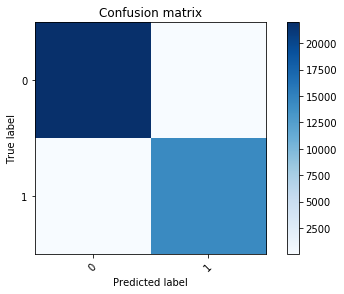

                  precision    recall  f1-score   support

               0       1.00      1.00      1.00     21980
               1       1.00      1.00      1.00     14417

        accuracy                           1.00     36397
       macro avg       1.00      1.00      1.00     36397
    weighted avg       1.00      1.00      1.00     36397

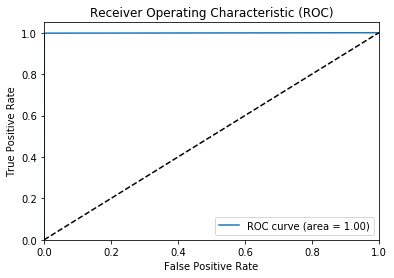

    RESULTS FOR ADAM/SIGMOID FULLY-CONNECTED MODEL
    -----------------------------------------------
    Test loss: 0.00592690466532228
    Test accuracy: 0.9984339475631714
    Final accuracy: 0.9984339368629283

    [[21951    29]
     [   28 14389]]

    Plotting confusion matrix

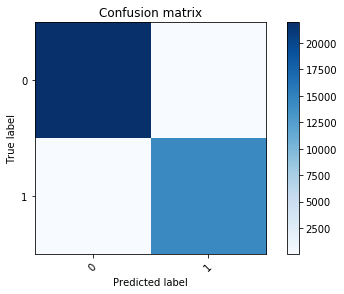

                  precision    recall  f1-score   support

               0       1.00      1.00      1.00     21980
               1       1.00      1.00      1.00     14417

        accuracy                           1.00     36397
       macro avg       1.00      1.00      1.00     36397
    weighted avg       1.00      1.00      1.00     36397

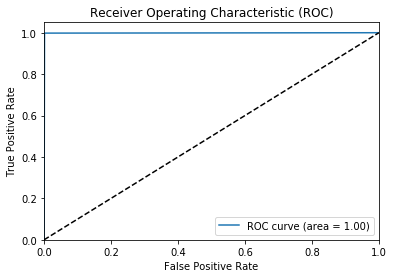

    RESULTS FOR ADAM/TANH FULLY-CONNECTED MODEL
    -----------------------------------------------
    Test loss: 0.006011422868309626
    Test accuracy: 0.9985988140106201
    Final accuracy: 0.998598785614199

    [[21968    12]
     [   39 14378]]

    Plotting confusion matrix

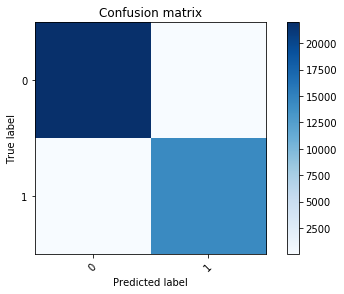

                  precision    recall  f1-score   support

               0       1.00      1.00      1.00     21980
               1       1.00      1.00      1.00     14417

        accuracy                           1.00     36397
       macro avg       1.00      1.00      1.00     36397
    weighted avg       1.00      1.00      1.00     36397

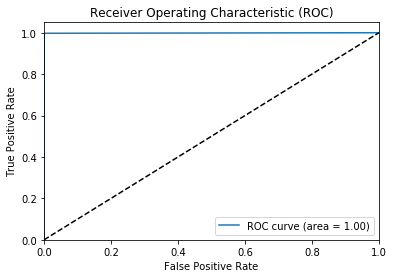

    RESULTS FOR SGD/RELU FULLY-CONNECTED MODEL
    -----------------------------------------------
    Test loss: 0.010092238724795881
    Test accuracy: 0.9982141256332397
    Final accuracy: 0.9982141385279006

    [[21954    26]
     [   39 14378]]

    Plotting confusion matrix

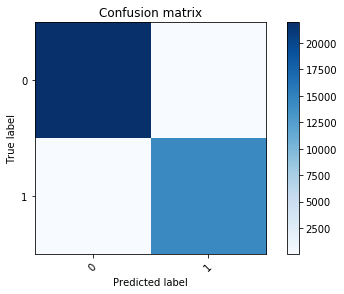

                  precision    recall  f1-score   support

               0       1.00      1.00      1.00     21980
               1       1.00      1.00      1.00     14417

        accuracy                           1.00     36397
       macro avg       1.00      1.00      1.00     36397
    weighted avg       1.00      1.00      1.00     36397

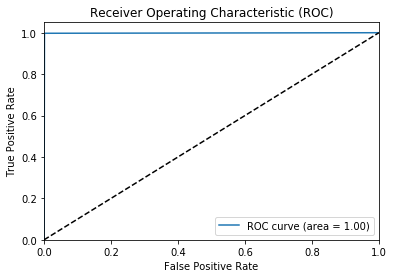

    RESULTS FOR SGD/SIGMOID FULLY-CONNECTED MODEL
    -----------------------------------------------
    Test loss: 0.009660156873271864
    Test accuracy: 0.9979668855667114
    Final accuracy: 0.9979668654009946

    [[21949    31]
     [   43 14374]]

    Plotting confusion matrix

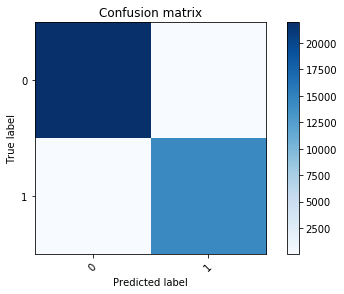

                  precision    recall  f1-score   support

               0       1.00      1.00      1.00     21980
               1       1.00      1.00      1.00     14417

        accuracy                           1.00     36397
       macro avg       1.00      1.00      1.00     36397
    weighted avg       1.00      1.00      1.00     36397

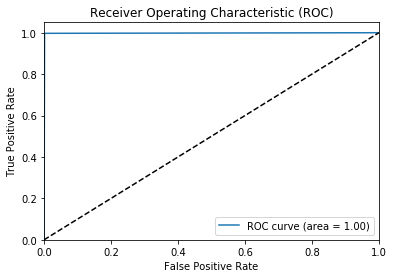

    RESULTS FOR SGD/TANH FULLY-CONNECTED MODEL
    -----------------------------------------------
    Test loss: 0.007358969800826868
    Test accuracy: 0.9982690811157227
    Final accuracy: 0.9982690881116576

    [[21956    24]
     [   39 14378]]

    Plotting confusion matrix

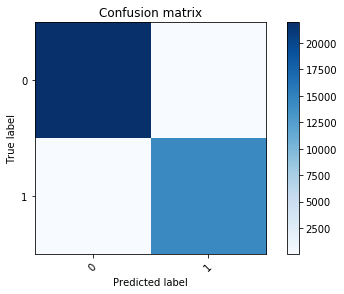

                  precision    recall  f1-score   support

               0       1.00      1.00      1.00     21980
               1       1.00      1.00      1.00     14417

        accuracy                           1.00     36397
       macro avg       1.00      1.00      1.00     36397
    weighted avg       1.00      1.00      1.00     36397

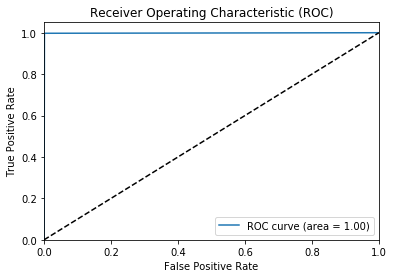

### **Convolution Neural Network**<a href="#Convolution-Neural-Network" class="anchor-link">¶</a>

In \[23\]:

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In \[24\]:

    y_train.shape

Out\[24\]:

    (109189, 2)

In \[25\]:

    y_test.shape

Out\[25\]:

    (36397, 2)

In \[26\]:

    x_train.shape

Out\[26\]:

    (109189, 116)

In \[27\]:

    x_test.shape

Out\[27\]:

    (36397, 116)

In \[28\]:

    def report_coef(names,coef,intercept):
        r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
        r = r[r.coef.abs()>0.01]
        r = r.sort_values(by=['coef'])
        r['coef'].plot(kind='barh', color=r['positive'].map({True: 'turquoise', False: 'maroon', }),fontsize = 20,figsize = (20,50))
        return list(r.index)

    regressor = LogisticRegression(penalty='l2',C=0.005, solver='lbfgs',max_iter=250, multi_class='multinomial')

    regressor.fit(x_train,y_train[:,1])

    pre = regressor.predict(x_test)

    names = list(df.columns.values)
    names.remove('outcome')
    best_features = report_coef(names,regressor.coef_[0],regressor.intercept_)

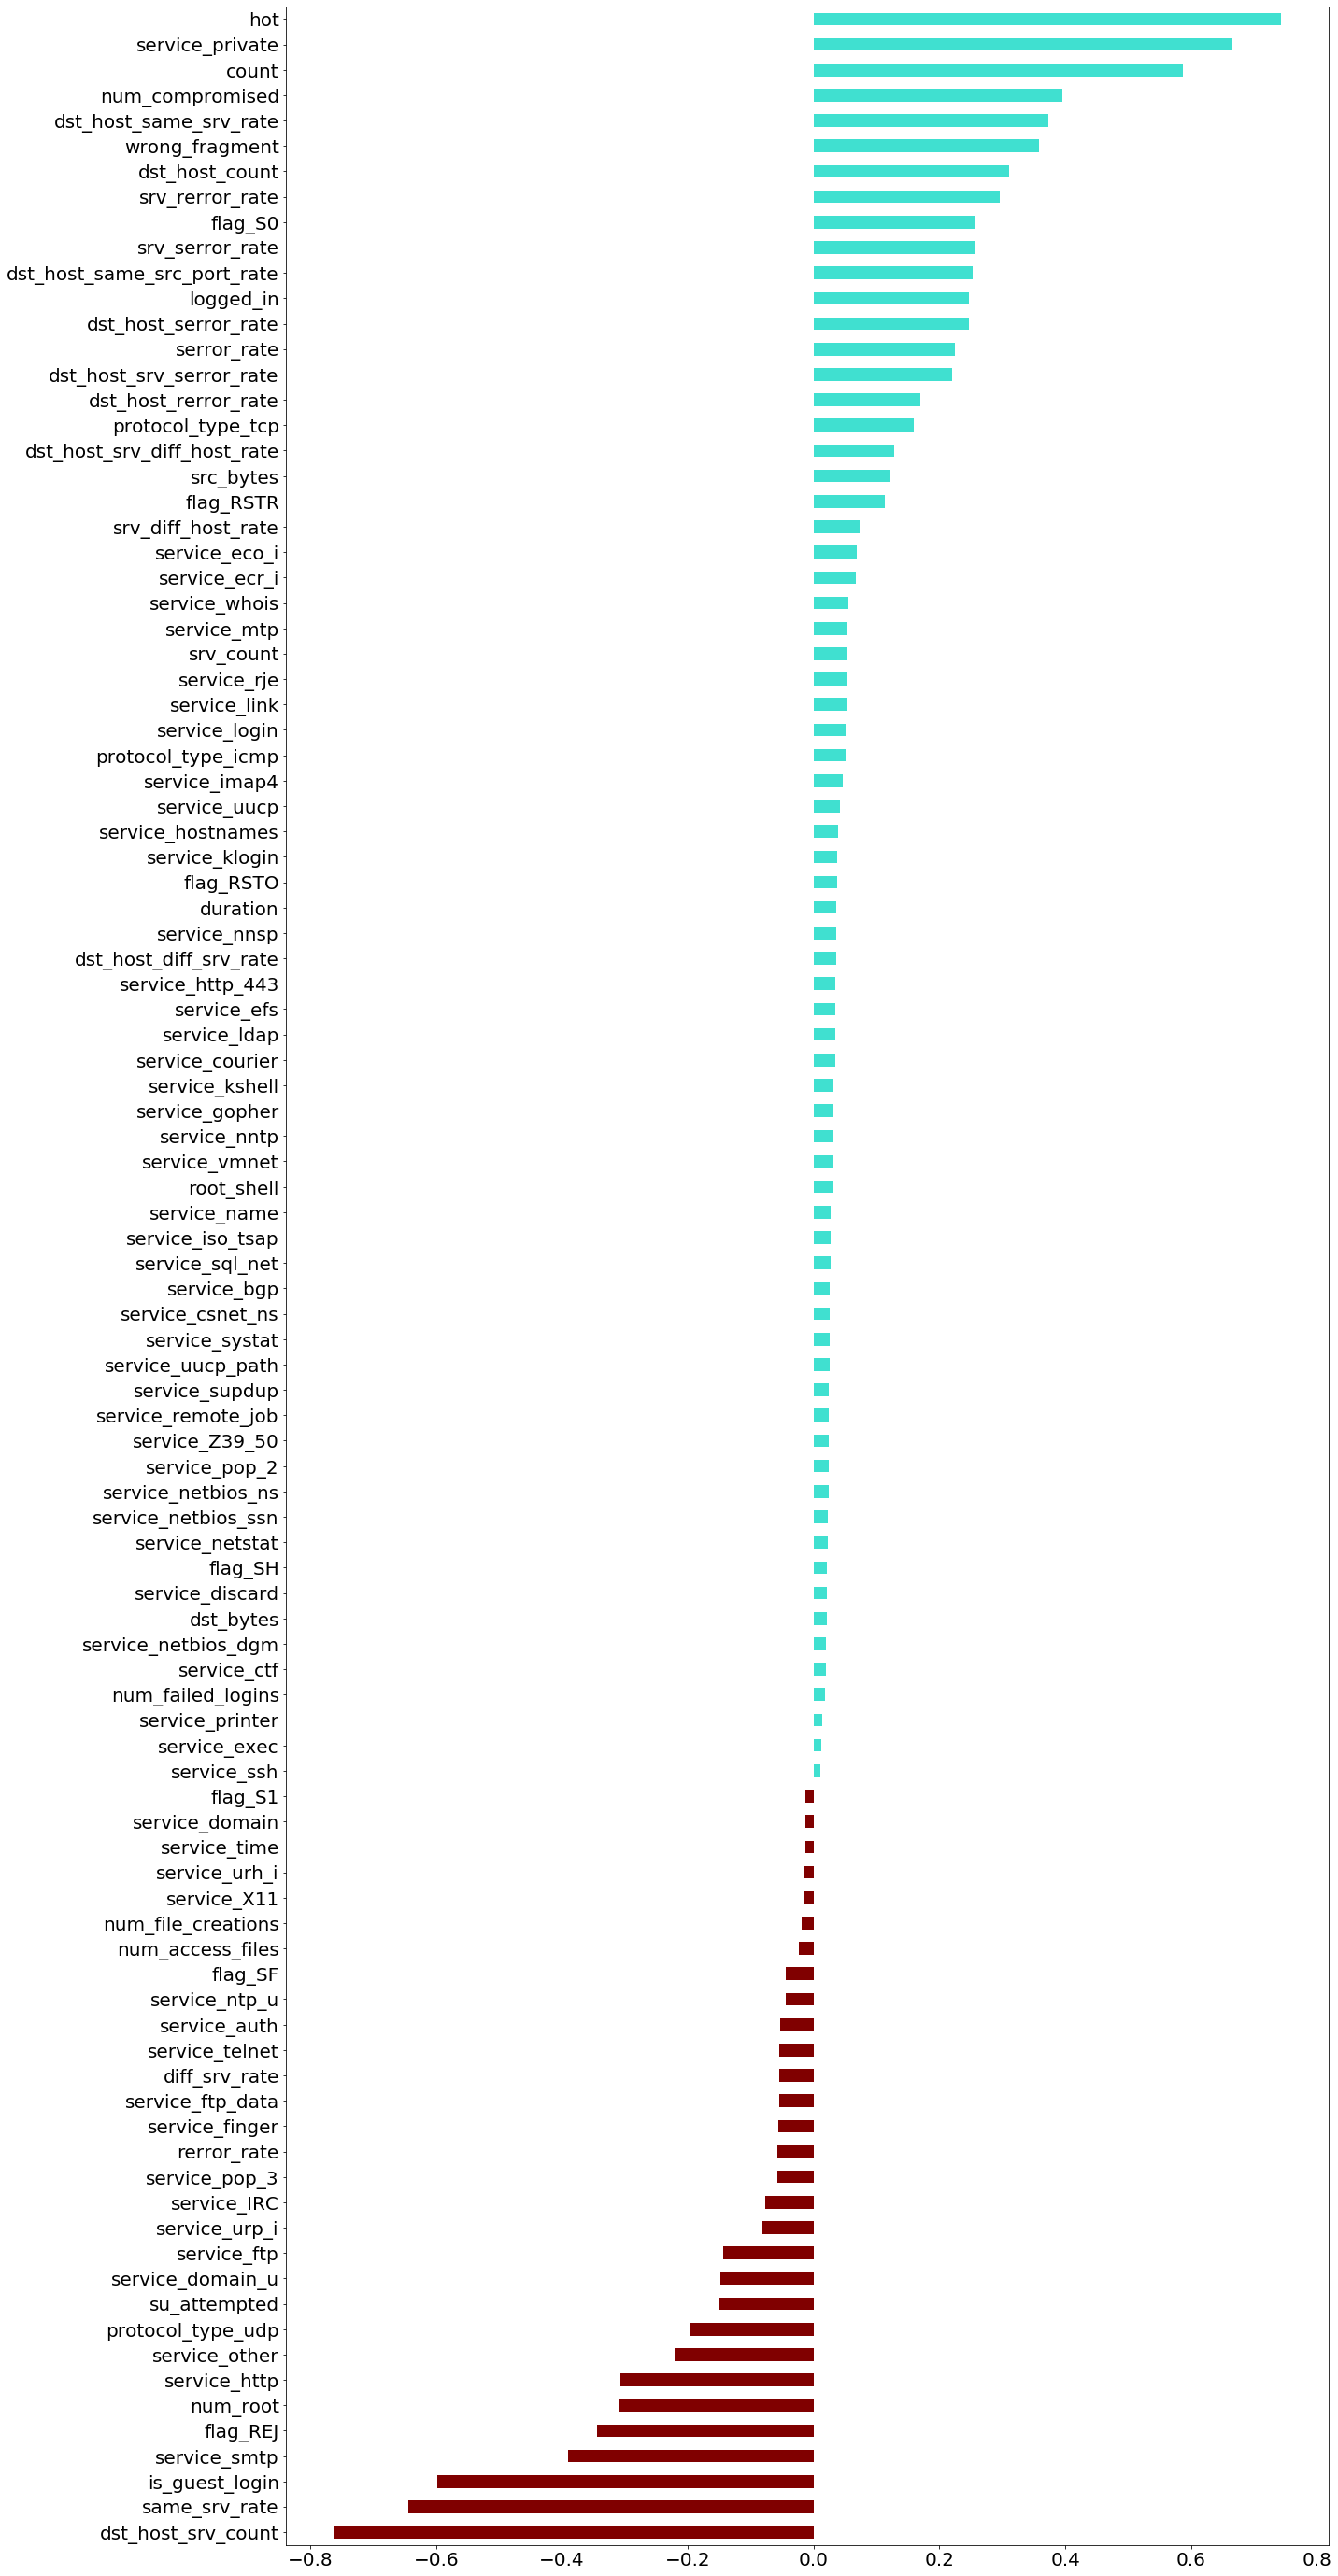

In \[29\]:

    x2 = df[best_features]
    x2

Out\[29\]:

|        | dst_host_srv_count | same_srv_rate | is_guest_login | service_smtp | flag_REJ | num_root | service_http | service_other | protocol_type_udp | su_attempted | ... | srv_serror_rate | flag_S0   | srv_rerror_rate | dst_host_count | wrong_fragment | dst_host_same_srv_rate | num_compromised | count     | service_private | hot       |
|--------|--------------------|---------------|----------------|--------------|----------|----------|--------------|---------------|-------------------|--------------|-----|-----------------|-----------|-----------------|----------------|----------------|------------------------|-----------------|-----------|-----------------|-----------|
| 0      | -1.054220          | 0.771732      | -0.068756      | -0.267485    | -0.33528 | -0.01039 | 1.160219     | -0.184028     | -0.303334         | -0.008613    | ... | -0.642797       | -0.639718 | -0.351068       | -1.740377      | -0.084394      | 0.979268               | -0.007905       | -0.661633 | -0.712886       | -0.070209 |
| 1      | -0.967047          | 0.771732      | -0.068756      | -0.267485    | -0.33528 | -0.01039 | 1.160219     | -0.184028     | -0.303334         | -0.008613    | ... | -0.642797       | -0.639718 | -0.351068       | -1.639467      | -0.084394      | 0.979268               | -0.007905       | -0.661633 | -0.712886       | -0.070209 |
| 2      | -0.879875          | 0.771732      | -0.068756      | -0.267485    | -0.33528 | -0.01039 | 1.160219     | -0.184028     | -0.303334         | -0.008613    | ... | -0.642797       | -0.639718 | -0.351068       | -1.538557      | -0.084394      | 0.979268               | -0.007905       | -0.661633 | -0.712886       | -0.070209 |
| 3      | -0.792702          | 0.771732      | -0.068756      | -0.267485    | -0.33528 | -0.01039 | 1.160219     | -0.184028     | -0.303334         | -0.008613    | ... | -0.642797       | -0.639718 | -0.351068       | -1.437647      | -0.084394      | 0.979268               | -0.007905       | -0.681566 | -0.712886       | -0.070209 |
| 4      | -0.705529          | 0.771732      | -0.068756      | -0.267485    | -0.33528 | -0.01039 | 1.160219     | -0.184028     | -0.303334         | -0.008613    | ... | -0.642797       | -0.639718 | -0.351068       | -1.336736      | -0.084394      | 0.979268               | -0.007905       | -0.681566 | -0.712886       | -0.070209 |
| ...    | ...                | ...           | ...            | ...          | ...      | ...      | ...          | ...           | ...               | ...          | ... | ...             | ...       | ...             | ...            | ...            | ...                    | ...             | ...       | ...             | ...       |
| 494016 | 1.090228           | 0.771732      | -0.068756      | -0.267485    | -0.33528 | -0.01039 | 1.160219     | -0.184028     | -0.303334         | -0.008613    | ... | -0.642797       | -0.639718 | -0.351068       | -0.963369      | -0.084394      | 0.979268               | -0.007905       | -0.701499 | -0.712886       | -0.070209 |
| 494017 | 1.090228           | 0.771732      | -0.068756      | -0.267485    | -0.33528 | -0.01039 | 1.160219     | -0.184028     | -0.303334         | -0.008613    | ... | -0.642797       | -0.639718 | -0.351068       | -1.770650      | -0.084394      | 0.979268               | -0.007905       | -0.681566 | -0.712886       | -0.070209 |
| 494018 | 1.090228           | 0.771732      | -0.068756      | -0.267485    | -0.33528 | -0.01039 | 1.160219     | -0.184028     | -0.303334         | -0.008613    | ... | -0.400274       | -0.639718 | -0.351068       | -1.669740      | -0.084394      | 0.979268               | -0.007905       | -0.681566 | -0.712886       | -0.070209 |
| 494019 | 1.090228           | 0.771732      | -0.068756      | -0.267485    | -0.33528 | -0.01039 | 1.160219     | -0.184028     | -0.303334         | -0.008613    | ... | -0.642797       | -0.639718 | -0.351068       | -1.568830      | -0.084394      | 0.979268               | -0.007905       | -0.681566 | -0.712886       | -0.070209 |
| 494020 | 1.090228           | 0.771732      | -0.068756      | -0.267485    | -0.33528 | -0.01039 | 1.160219     | -0.184028     | -0.303334         | -0.008613    | ... | -0.642797       | -0.639718 | -0.351068       | -1.770650      | -0.084394      | 0.979268               | -0.007905       | -0.681566 | -0.712886       | -0.070209 |

145586 rows × 100 columns

In \[30\]:

    x2.to_csv("network_intrusion_data_x.csv", index=False)

In \[31\]:

    x_train, x_test, y_train, y_test = train_test_split(x2, y, test_size=0.25, random_state=42)

In \[32\]:

    x_train.shape

Out\[32\]:

    (109189, 100)

In \[33\]:

    x_test.shape

Out\[33\]:

    (36397, 100)

In \[34\]:

    y_train.shape

Out\[34\]:

    (109189, 2)

In \[35\]:

    y_test.shape

Out\[35\]:

    (36397, 2)

In \[36\]:

    img_rows, img_cols = 10,10

In \[37\]:

    x_train = np.array(x_train).reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = np.array(x_test).reshape(x_test.shape[0], img_rows, img_cols, 1)

### **CNN Model with 2 layers, kernel size 2x2**<a href="#CNN-Model-with-2-layers,-kernel-size-2x2" class="anchor-link">¶</a>

In \[39\]:

    checkpointer = ModelCheckpoint(filepath="best_weight_2_2x2.hdf5", verbose=2, save_best_only=True)

    cnn_mod = Sequential()
    cnn_mod.add(Conv2D(32, kernel_size=(2, 2), strides=(1, 1),
                     activation='relu', padding='valid',
                     input_shape=(img_rows, img_cols, 1)))

    cnn_mod.add(MaxPooling2D(pool_size=(1,1), strides=(1,1)))
    cnn_mod.add(Conv2D(64, (2, 2), activation='relu'))
    cnn_mod.add(MaxPooling2D(pool_size=(1, 1)))
    cnn_mod.add(Dropout(0.1))
    cnn_mod.add(Flatten())
    cnn_mod.add(Dense(250, activation='relu'))
    cnn_mod.add(Dropout(0.1))

    cnn_mod.add(Dense(2, activation="softmax"))

    # define optimizer and objective, compile cnn_mod

    cnn_mod.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=0, mode='auto')

    start_time = time.time()

    cnn_mod.fit(x_train, y_train,epochs=100,verbose=2,
                callbacks=[monitor, checkpointer],validation_data=(x_test, y_test))

    cnn_mod.load_weights("best_weight_2_2x2.hdf5")

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time)))

    Train on 109189 samples, validate on 36397 samples
    Epoch 1/100

    Epoch 00001: val_loss improved from inf to 0.01792, saving model to best_weight_2_2x2.hdf5
    109189/109189 - 210s - loss: 0.0224 - accuracy: 0.9941 - val_loss: 0.0179 - val_accuracy: 0.9947
    Epoch 2/100

    Epoch 00002: val_loss improved from 0.01792 to 0.00817, saving model to best_weight_2_2x2.hdf5
    109189/109189 - 186s - loss: 0.0097 - accuracy: 0.9973 - val_loss: 0.0082 - val_accuracy: 0.9980
    Epoch 3/100

    Epoch 00003: val_loss did not improve from 0.00817
    109189/109189 - 195s - loss: 0.0085 - accuracy: 0.9976 - val_loss: 0.0084 - val_accuracy: 0.9985
    Epoch 4/100

    Epoch 00004: val_loss improved from 0.00817 to 0.00728, saving model to best_weight_2_2x2.hdf5
    109189/109189 - 182s - loss: 0.0083 - accuracy: 0.9978 - val_loss: 0.0073 - val_accuracy: 0.9984
    Elapsed time: 0:12:52.46

### **Result and Confusion Matrix for 2 CONV layers, 2x2 size kernel**<a href="#Result-and-Confusion-Matrix-for-2-CONV-layers,-2x2-size-kernel" class="anchor-link">¶</a>

In \[40\]:

    pred = cnn_mod.predict(x_test)

    predict = np.argmax(pred,axis=1)
    y_true = np.argmax(y_test,axis=1)

    score = cnn_mod.evaluate(x_test, y_test, verbose=0)
    print('Test loss: {}'.format(score[0]))
    print('Test accuracy: {}'.format(score[1]))
    score = metrics.accuracy_score(y_true, predict)
    print("Final accuracy: {}".format(score))

    # Displaying confusion matrix
    cm = confusion_matrix(y_true, predict)
    print(cm)


    print('Plotting confusion matrix')
    plt.figure()
    plot_confusion_matrix(cm, [0,1])
    plt.show()

    # Displays precision, recall, and F1 scores
    print(classification_report(y_true, predict))

    # Creating ROC Curve
    pred_roc = cnn_mod.predict(x_test)
    pred_roc = pred_roc[:,1] # Only positive class (M)
    plot_roc(predict,y_true)

    Test loss: 0.007283561020582126
    Test accuracy: 0.9984339475631714
    Final accuracy: 0.9984339368629283
    [[21953    27]
     [   30 14387]]
    Plotting confusion matrix

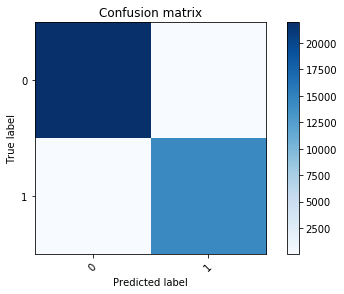

                  precision    recall  f1-score   support

               0       1.00      1.00      1.00     21980
               1       1.00      1.00      1.00     14417

        accuracy                           1.00     36397
       macro avg       1.00      1.00      1.00     36397
    weighted avg       1.00      1.00      1.00     36397

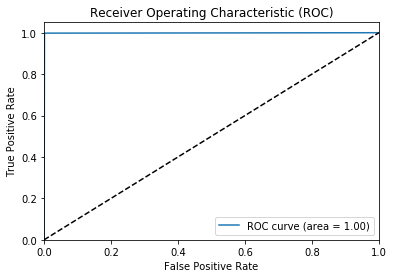

### **CNN Model with 2 layers, kernel size 3x3**<a href="#CNN-Model-with-2-layers,-kernel-size-3x3" class="anchor-link">¶</a>

In \[41\]:

    checkpointer = ModelCheckpoint(filepath="best_weight_2_3x3.hdf5", verbose=2, save_best_only=True)

    cnn_mod = Sequential()
    cnn_mod.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                     activation='relu', padding='valid',
                     input_shape=(img_rows, img_cols, 1)))

    cnn_mod.add(MaxPooling2D(pool_size=(1,1), strides=(1,1)))
    cnn_mod.add(Conv2D(64, (3, 3), activation='relu'))
    cnn_mod.add(MaxPooling2D(pool_size=(1, 1)))
    cnn_mod.add(Dropout(0.1))
    cnn_mod.add(Flatten())
    cnn_mod.add(Dense(250, activation='relu'))
    cnn_mod.add(Dropout(0.1))

    cnn_mod.add(Dense(2, activation="softmax"))

    # define optimizer and objective, compile cnn_mod

    cnn_mod.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=0, mode='auto')

    start_time = time.time()

    cnn_mod.fit(x_train, y_train,epochs=100,verbose=2,
                callbacks=[monitor, checkpointer],validation_data=(x_test, y_test))

    cnn_mod.load_weights("best_weight_2_3x3.hdf5")

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time)))

    Train on 109189 samples, validate on 36397 samples
    Epoch 1/100

    Epoch 00001: val_loss improved from inf to 0.00850, saving model to best_weight_2_3x3.hdf5
    109189/109189 - 126s - loss: 0.0252 - accuracy: 0.9936 - val_loss: 0.0085 - val_accuracy: 0.9975
    Epoch 2/100

    Epoch 00002: val_loss did not improve from 0.00850
    109189/109189 - 117s - loss: 0.0106 - accuracy: 0.9970 - val_loss: 0.0099 - val_accuracy: 0.9973
    Epoch 3/100

    Epoch 00003: val_loss improved from 0.00850 to 0.00781, saving model to best_weight_2_3x3.hdf5
    109189/109189 - 114s - loss: 0.0088 - accuracy: 0.9973 - val_loss: 0.0078 - val_accuracy: 0.9984
    Elapsed time: 0:05:57.35

### **Result and Confusion Matrix for 2 Conv Layers, 3x3 kernel size**<a href="#Result-and-Confusion-Matrix-for-2-Conv-Layers,-3x3-kernel-size" class="anchor-link">¶</a>

In \[42\]:

    pred = cnn_mod.predict(x_test)

    predict = np.argmax(pred,axis=1)
    y_true = np.argmax(y_test,axis=1)

    score = cnn_mod.evaluate(x_test, y_test, verbose=0)
    print('Test loss: {}'.format(score[0]))
    print('Test accuracy: {}'.format(score[1]))
    score = metrics.accuracy_score(y_true, predict)
    print("Final accuracy: {}".format(score))
    print()

    # Displaying confusion matrix
    cm = confusion_matrix(y_true, predict)
    print(cm)


    print('Plotting confusion matrix')
    plt.figure()
    plot_confusion_matrix(cm, [0,1])
    plt.show()

    # Displays precision, recall, and F1 scores
    print(classification_report(y_true, predict))

    # Creating ROC Curve
    pred_roc = cnn_mod.predict(x_test)
    pred_roc = pred_roc[:,1] # Only positive class (M)
    plot_roc(predict,y_true)

    Test loss: 0.0078122395070742675
    Test accuracy: 0.998351514339447
    Final accuracy: 0.9983515124872929

    [[21956    24]
     [   36 14381]]
    Plotting confusion matrix

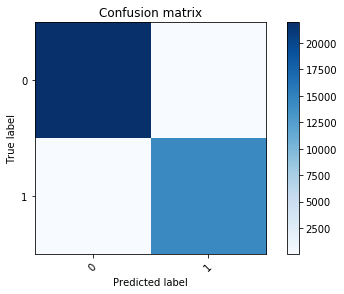

                  precision    recall  f1-score   support

               0       1.00      1.00      1.00     21980
               1       1.00      1.00      1.00     14417

        accuracy                           1.00     36397
       macro avg       1.00      1.00      1.00     36397
    weighted avg       1.00      1.00      1.00     36397

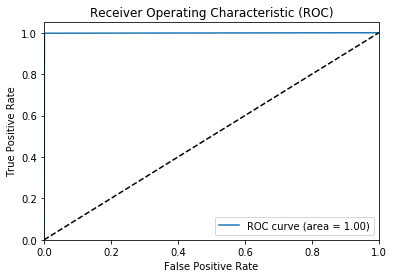

### **CNN Model with 2 layers, kernel size 4x4**<a href="#CNN-Model-with-2-layers,-kernel-size-4x4" class="anchor-link">¶</a>

In \[43\]:

    checkpointer = ModelCheckpoint(filepath="best_weight_2_4x4.hdf5", verbose=2, save_best_only=True)

    cnn_mod = Sequential()
    cnn_mod.add(Conv2D(32, kernel_size=(4, 4), strides=(1, 1),
                     activation='relu', padding='valid',
                     input_shape=(img_rows, img_cols, 1)))

    cnn_mod.add(MaxPooling2D(pool_size=(1,1), strides=(1,1)))
    cnn_mod.add(Conv2D(64, (4, 4), activation='relu'))
    cnn_mod.add(MaxPooling2D(pool_size=(1, 1)))
    cnn_mod.add(Dropout(0.1))
    cnn_mod.add(Flatten())
    cnn_mod.add(Dense(250, activation='relu'))
    cnn_mod.add(Dropout(0.1))

    cnn_mod.add(Dense(2, activation="softmax"))

    # define optimizer and objective, compile cnn_mod

    cnn_mod.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=0, mode='auto')

    start_time = time.time()

    cnn_mod.fit(x_train, y_train,epochs=100,verbose=2,
                callbacks=[monitor, checkpointer],validation_data=(x_test, y_test))

    cnn_mod.load_weights("best_weight_2_4x4.hdf5")

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time)))

    Train on 109189 samples, validate on 36397 samples
    Epoch 1/100

    Epoch 00001: val_loss improved from inf to 0.00941, saving model to best_weight_2_4x4.hdf5
    109189/109189 - 77s - loss: 0.0280 - accuracy: 0.9928 - val_loss: 0.0094 - val_accuracy: 0.9970
    Epoch 2/100

    Epoch 00002: val_loss did not improve from 0.00941
    109189/109189 - 85s - loss: 0.0113 - accuracy: 0.9967 - val_loss: 0.0187 - val_accuracy: 0.9932
    Epoch 3/100

    Epoch 00003: val_loss improved from 0.00941 to 0.00871, saving model to best_weight_2_4x4.hdf5
    109189/109189 - 79s - loss: 0.0099 - accuracy: 0.9972 - val_loss: 0.0087 - val_accuracy: 0.9981
    Elapsed time: 0:04:01.50

### **Result and Confusion Matrix for 2 Conv Layers, 4x4 kernel size**<a href="#Result-and-Confusion-Matrix-for-2-Conv-Layers,-4x4-kernel-size" class="anchor-link">¶</a>

In \[44\]:

    pred = cnn_mod.predict(x_test)

    predict = np.argmax(pred,axis=1)
    y_true = np.argmax(y_test,axis=1)

    score = cnn_mod.evaluate(x_test, y_test, verbose=0)
    print('Test loss: {}'.format(score[0]))
    print('Test accuracy: {}'.format(score[1]))
    score = metrics.accuracy_score(y_true, predict)
    print("Final accuracy: {}".format(score))
    print()

    # Displaying confusion matrix
    cm = confusion_matrix(y_true, predict)
    print(cm)


    print('Plotting confusion matrix')
    plt.figure()
    plot_confusion_matrix(cm, [0,1])
    plt.show()

    # Displays precision, recall, and F1 scores
    print(classification_report(y_true, predict))

    # Creating ROC Curve
    pred_roc = cnn_mod.predict(x_test)
    pred_roc = pred_roc[:,1] # Only positive class (M)
    plot_roc(predict,y_true)

    Test loss: 0.008711894728486321
    Test accuracy: 0.9980767369270325
    Final accuracy: 0.9980767645685084

    [[21951    29]
     [   41 14376]]
    Plotting confusion matrix

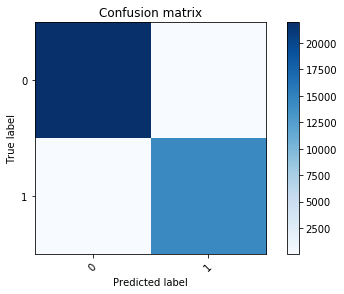

                  precision    recall  f1-score   support

               0       1.00      1.00      1.00     21980
               1       1.00      1.00      1.00     14417

        accuracy                           1.00     36397
       macro avg       1.00      1.00      1.00     36397
    weighted avg       1.00      1.00      1.00     36397

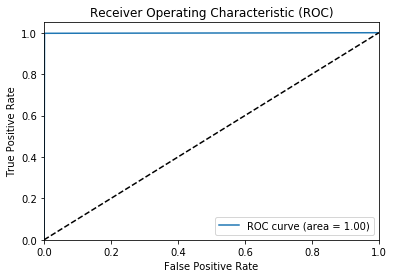

### **CNN Model with 3 layers, kernel size 2x2**<a href="#CNN-Model-with-3-layers,-kernel-size-2x2" class="anchor-link">¶</a>

In \[45\]:

    checkpointer = ModelCheckpoint(filepath="best_weight_3_2x2.hdf5", verbose=2, save_best_only=True)

    cnn_mod = Sequential()
    cnn_mod.add(Conv2D(32, kernel_size=(2, 2), strides=(2, 2),
                     activation='relu', padding='valid',
                     input_shape=(img_rows, img_cols, 1)))

    cnn_mod.add(MaxPooling2D(pool_size=(1,1), strides=(1,1)))
    cnn_mod.add(Conv2D(64, (2, 2), activation='relu'))
    cnn_mod.add(MaxPooling2D(pool_size=(1, 1)))
    cnn_mod.add(Conv2D(128, (2,2), activation='relu'))
    cnn_mod.add(MaxPooling2D(pool_size=(1, 1)))
    cnn_mod.add(Dropout(0.1))
    cnn_mod.add(Flatten())
    cnn_mod.add(Dense(250, activation='relu'))
    cnn_mod.add(Dropout(0.1))

    cnn_mod.add(Dense(2, activation="softmax"))

    # define optimizer and objective, compile cnn_mod

    cnn_mod.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=0, mode='auto')

    start_time = time.time()

    cnn_mod.fit(x_train, y_train,epochs=100,verbose=2,
                callbacks=[monitor, checkpointer],validation_data=(x_test, y_test))

    cnn_mod.load_weights("best_weight_3_2x2.hdf5")

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time)))

    Train on 109189 samples, validate on 36397 samples
    Epoch 1/100

    Epoch 00001: val_loss improved from inf to 0.01017, saving model to best_weight_3_2x2.hdf5
    109189/109189 - 88s - loss: 0.0217 - accuracy: 0.9943 - val_loss: 0.0102 - val_accuracy: 0.9968
    Epoch 2/100

    Epoch 00002: val_loss improved from 0.01017 to 0.00786, saving model to best_weight_3_2x2.hdf5
    109189/109189 - 86s - loss: 0.0109 - accuracy: 0.9969 - val_loss: 0.0079 - val_accuracy: 0.9985
    Epoch 3/100

    Epoch 00003: val_loss improved from 0.00786 to 0.00660, saving model to best_weight_3_2x2.hdf5
    109189/109189 - 90s - loss: 0.0091 - accuracy: 0.9974 - val_loss: 0.0066 - val_accuracy: 0.9982
    Epoch 4/100

    Epoch 00004: val_loss improved from 0.00660 to 0.00520, saving model to best_weight_3_2x2.hdf5
    109189/109189 - 102s - loss: 0.0082 - accuracy: 0.9978 - val_loss: 0.0052 - val_accuracy: 0.9987
    Epoch 5/100

    Epoch 00005: val_loss did not improve from 0.00520
    109189/109189 - 96s - loss: 0.0076 - accuracy: 0.9978 - val_loss: 0.0101 - val_accuracy: 0.9963
    Epoch 6/100

    Epoch 00006: val_loss did not improve from 0.00520
    109189/109189 - 89s - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.0104 - val_accuracy: 0.9984
    Elapsed time: 0:09:11.81

### **Result and Confusion Matrix 3 Conv layers, 2x2 kernel size**<a href="#Result-and-Confusion-Matrix-3-Conv-layers,-2x2-kernel-size" class="anchor-link">¶</a>

In \[46\]:

    pred = cnn_mod.predict(x_test)

    predict = np.argmax(pred,axis=1)
    y_true = np.argmax(y_test,axis=1)

    score = cnn_mod.evaluate(x_test, y_test, verbose=0)
    print('Test loss: {}'.format(score[0]))
    print('Test accuracy: {}'.format(score[1]))
    score = metrics.accuracy_score(y_true, predict)
    print("Final accuracy: {}".format(score))
    print()

    # Displaying confusion matrix
    cm = confusion_matrix(y_true, predict)
    print(cm)


    print('Plotting confusion matrix')
    plt.figure()
    plot_confusion_matrix(cm, [0,1])
    plt.show()

    # Displays precision, recall, and F1 scores
    print(classification_report(y_true, predict))

    # Creating ROC Curve
    pred_roc = cnn_mod.predict(x_test)
    pred_roc = pred_roc[:,1] # Only positive class (M)
    plot_roc(predict,y_true)

    Test loss: 0.0051977557854710746
    Test accuracy: 0.9987086653709412
    Final accuracy: 0.9987086847817128

    [[21969    11]
     [   36 14381]]
    Plotting confusion matrix

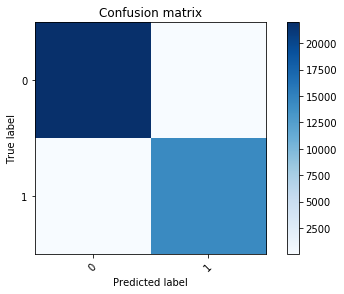

                  precision    recall  f1-score   support

               0       1.00      1.00      1.00     21980
               1       1.00      1.00      1.00     14417

        accuracy                           1.00     36397
       macro avg       1.00      1.00      1.00     36397
    weighted avg       1.00      1.00      1.00     36397

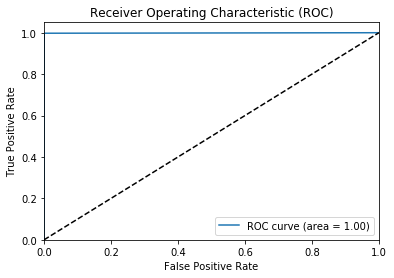

### **CNN Model with 3 layers, kernel size: 3x3**<a href="#CNN-Model-with-3-layers,-kernel-size:-3x3" class="anchor-link">¶</a>

In \[47\]:

    checkpointer = ModelCheckpoint(filepath="best_weight_3_3x3.hdf5", verbose=2, save_best_only=True)

    cnn_mod = Sequential()
    cnn_mod.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                     activation='relu', padding='valid',
                     input_shape=(img_rows, img_cols, 1)))

    cnn_mod.add(MaxPooling2D(pool_size=(1,1), strides=(1,1)))
    cnn_mod.add(Conv2D(64, (3, 3), activation='relu'))
    cnn_mod.add(MaxPooling2D(pool_size=(1, 1)))
    cnn_mod.add(Conv2D(128, (3,3), activation='relu'))
    cnn_mod.add(MaxPooling2D(pool_size=(1, 1)))
    cnn_mod.add(Dropout(0.1))
    cnn_mod.add(Flatten())
    cnn_mod.add(Dense(250, activation='relu'))
    cnn_mod.add(Dropout(0.1))

    cnn_mod.add(Dense(2, activation="softmax"))

    # define optimizer and objective, compile cnn_mod

    cnn_mod.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=0, mode='auto')

    start_time = time.time()

    cnn_mod.fit(x_train, y_train,epochs=100,verbose=2,
                callbacks=[monitor, checkpointer],validation_data=(x_test, y_test))

    cnn_mod.load_weights("best_weight_3_3x3.hdf5")

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time)))

    Train on 109189 samples, validate on 36397 samples
    Epoch 1/100

    Epoch 00001: val_loss improved from inf to 0.01037, saving model to best_weight_3_3x3.hdf5
    109189/109189 - 153s - loss: 0.0271 - accuracy: 0.9926 - val_loss: 0.0104 - val_accuracy: 0.9978
    Epoch 2/100

    Epoch 00002: val_loss improved from 0.01037 to 0.00793, saving model to best_weight_3_3x3.hdf5
    109189/109189 - 145s - loss: 0.0115 - accuracy: 0.9968 - val_loss: 0.0079 - val_accuracy: 0.9979
    Epoch 3/100

    Epoch 00003: val_loss did not improve from 0.00793
    109189/109189 - 145s - loss: 0.0099 - accuracy: 0.9970 - val_loss: 0.0102 - val_accuracy: 0.9979
    Epoch 4/100

    Epoch 00004: val_loss improved from 0.00793 to 0.00596, saving model to best_weight_3_3x3.hdf5
    109189/109189 - 386s - loss: 0.0089 - accuracy: 0.9975 - val_loss: 0.0060 - val_accuracy: 0.9981
    Epoch 5/100

    Epoch 00005: val_loss improved from 0.00596 to 0.00500, saving model to best_weight_3_3x3.hdf5
    109189/109189 - 204s - loss: 0.0081 - accuracy: 0.9977 - val_loss: 0.0050 - val_accuracy: 0.9988
    Epoch 6/100

    Epoch 00006: val_loss improved from 0.00500 to 0.00468, saving model to best_weight_3_3x3.hdf5
    109189/109189 - 189s - loss: 0.0073 - accuracy: 0.9979 - val_loss: 0.0047 - val_accuracy: 0.9987
    Epoch 7/100

    Epoch 00007: val_loss did not improve from 0.00468
    109189/109189 - 164s - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.0081 - val_accuracy: 0.9987
    Epoch 8/100

    Epoch 00008: val_loss did not improve from 0.00468
    109189/109189 - 188s - loss: 0.0063 - accuracy: 0.9980 - val_loss: 0.0075 - val_accuracy: 0.9986
    Elapsed time: 0:26:13.80

### **Result and Confusion Matrix 3 Conv Layers, 3x3 kernel size**<a href="#Result-and-Confusion-Matrix-3-Conv-Layers,-3x3-kernel-size" class="anchor-link">¶</a>

In \[48\]:

    pred = cnn_mod.predict(x_test)

    predict = np.argmax(pred,axis=1)
    y_true = np.argmax(y_test,axis=1)

    score = cnn_mod.evaluate(x_test, y_test, verbose=0)
    print('Test loss: {}'.format(score[0]))
    print('Test accuracy: {}'.format(score[1]))
    score = metrics.accuracy_score(y_true, predict)
    print("Final accuracy: {}".format(score))
    print()

    # Displaying confusion matrix
    cm = confusion_matrix(y_true, predict)
    print(cm)


    print('Plotting confusion matrix')
    plt.figure()
    plot_confusion_matrix(cm, [0,1])
    plt.show()

    # Displays precision, recall, and F1 scores
    print(classification_report(y_true, predict))

    # Creating ROC Curve
    pred_roc = cnn_mod.predict(x_test)
    pred_roc = pred_roc[:,1] # Only positive class (M)
    plot_roc(predict,y_true)

    Test loss: 0.004681052796228505
    Test accuracy: 0.9987361431121826
    Final accuracy: 0.9987361595735912

    [[21951    29]
     [   17 14400]]
    Plotting confusion matrix

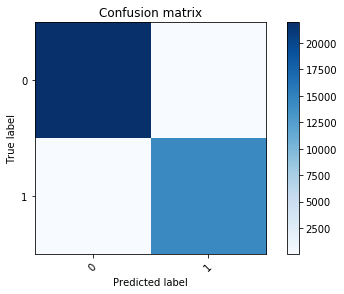

                  precision    recall  f1-score   support

               0       1.00      1.00      1.00     21980
               1       1.00      1.00      1.00     14417

        accuracy                           1.00     36397
       macro avg       1.00      1.00      1.00     36397
    weighted avg       1.00      1.00      1.00     36397

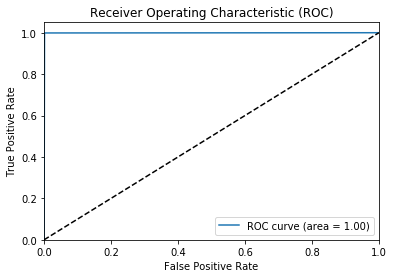

### **CNN Model with 3 layers, kernel size: 4x4**<a href="#CNN-Model-with-3-layers,-kernel-size:-4x4" class="anchor-link">¶</a>

In \[49\]:

    checkpointer = ModelCheckpoint(filepath="best_weight_3_4x4.hdf5", verbose=2, save_best_only=True)

    cnn_mod = Sequential()
    cnn_mod.add(Conv2D(32, kernel_size=(4, 4), strides=(1, 1),
                     activation='relu', padding='valid',
                     input_shape=(img_rows, img_cols, 1)))

    cnn_mod.add(MaxPooling2D(pool_size=(1,1), strides=(1,1)))
    cnn_mod.add(Conv2D(64, (4, 4), activation='relu'))
    cnn_mod.add(MaxPooling2D(pool_size=(1, 1)))
    cnn_mod.add(Conv2D(128, (4,4), activation='relu'))
    cnn_mod.add(MaxPooling2D(pool_size=(1, 1)))
    cnn_mod.add(Dropout(0.1))
    cnn_mod.add(Flatten())
    cnn_mod.add(Dense(250, activation='relu'))
    cnn_mod.add(Dropout(0.1))

    cnn_mod.add(Dense(2, activation="softmax"))

    # define optimizer and objective, compile cnn_mod

    cnn_mod.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=0, mode='auto')

    start_time = time.time()

    cnn_mod.fit(x_train, y_train,epochs=100,verbose=2,
                callbacks=[monitor, checkpointer],validation_data=(x_test, y_test))

    cnn_mod.load_weights("best_weight_3_4x4.hdf5")

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time)))

    Train on 109189 samples, validate on 36397 samples
    Epoch 1/100

    Epoch 00001: val_loss improved from inf to 0.00895, saving model to best_weight_3_4x4.hdf5
    109189/109189 - 108s - loss: 0.0279 - accuracy: 0.9927 - val_loss: 0.0090 - val_accuracy: 0.9975
    Epoch 2/100

    Epoch 00002: val_loss did not improve from 0.00895
    109189/109189 - 105s - loss: 0.0121 - accuracy: 0.9965 - val_loss: 0.0110 - val_accuracy: 0.9972
    Epoch 3/100

    Epoch 00003: val_loss did not improve from 0.00895
    109189/109189 - 112s - loss: 0.0104 - accuracy: 0.9971 - val_loss: 0.0100 - val_accuracy: 0.9983
    Elapsed time: 0:05:25.22

### **Result and Confusion Matrix 3 Conv Layers, 4x4 kernel size**<a href="#Result-and-Confusion-Matrix-3-Conv-Layers,-4x4-kernel-size" class="anchor-link">¶</a>

In \[50\]:

    pred = cnn_mod.predict(x_test)

    predict = np.argmax(pred,axis=1)
    y_true = np.argmax(y_test,axis=1)

    score = cnn_mod.evaluate(x_test, y_test, verbose=0)
    print('Test loss: {}'.format(score[0]))
    print('Test accuracy: {}'.format(score[1]))
    score = metrics.accuracy_score(y_true, predict)
    print("Final accuracy: {}".format(score))
    print()

    # Displaying confusion matrix
    cm = confusion_matrix(y_true, predict)
    print(cm)


    print('Plotting confusion matrix')
    plt.figure()
    plot_confusion_matrix(cm, [0,1])
    plt.show()

    # Displays precision, recall, and F1 scores
    print(classification_report(y_true, predict))

    # Creating ROC Curve
    pred_roc = cnn_mod.predict(x_test)
    pred_roc = pred_roc[:,1] # Only positive class (M)
    plot_roc(predict,y_true)

    Test loss: 0.008954405272378878
    Test accuracy: 0.99747234582901
    Final accuracy: 0.9974723191471825

    [[21939    41]
     [   51 14366]]
    Plotting confusion matrix

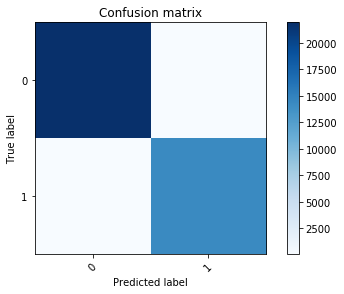

                  precision    recall  f1-score   support

               0       1.00      1.00      1.00     21980
               1       1.00      1.00      1.00     14417

        accuracy                           1.00     36397
       macro avg       1.00      1.00      1.00     36397
    weighted avg       1.00      1.00      1.00     36397

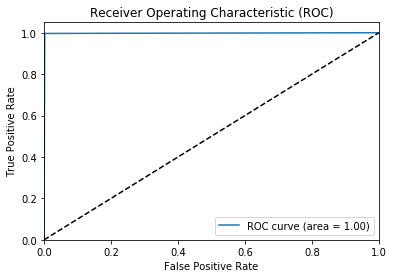

### ALL CNN RESULTS<a href="#ALL-CNN-RESULTS" class="anchor-link">¶</a>

In \[51\]:

    cnn1 = load_model('best_weight_2_2x2.hdf5') # load weights
    pred1 = cnn1.predict(x_test)
    predict = np.argmax(pred1,axis=1)
    y_true = np.argmax(y_test,axis=1)
    score1 = cnn1.evaluate(x_test, y_test, verbose=0)
    score1 = metrics.accuracy_score(y_true, predict)
    print("2L-2x2 Accuracy: ", score1,"\n")


    cnn2 = load_model('best_weight_2_3x3.hdf5') # load weights
    pred2 = cnn2.predict(x_test)
    predict = np.argmax(pred2,axis=1)
    y_true = np.argmax(y_test,axis=1)
    score2 = cnn2.evaluate(x_test, y_test, verbose=0)
    score2 = metrics.accuracy_score(y_true, predict)
    print("2L-3x3 Accuracy: ", score2,"\n")

    cnn3 = load_model('best_weight_2_4x4.hdf5') # load weights
    pred3 = cnn3.predict(x_test)
    predict = np.argmax(pred3,axis=1)
    y_true = np.argmax(y_test,axis=1)
    score3 = cnn3.evaluate(x_test, y_test, verbose=0)
    score3 = metrics.accuracy_score(y_true, predict)
    print("2L-4x4 Accuracy: ", score3,"\n")

    cnn4 = load_model('best_weight_3_2x2.hdf5') # load weights
    pred4 = cnn4.predict(x_test)
    predict = np.argmax(pred4,axis=1)
    y_true = np.argmax(y_test,axis=1)
    score4 = cnn4.evaluate(x_test, y_test, verbose=0)
    score4 = metrics.accuracy_score(y_true, predict)
    print("3L-2x2 Accuracy: ", score4,"\n")

    cnn5 = load_model('best_weight_3_3x3.hdf5') # load weights
    pred5 = cnn5.predict(x_test)
    predict = np.argmax(pred5,axis=1)
    y_true = np.argmax(y_test,axis=1)
    score5 = cnn5.evaluate(x_test, y_test, verbose=0)
    score5 = metrics.accuracy_score(y_true, predict)
    print("3L-3x3 Accuracy: ", score5,"\n")

    cnn6 = load_model('best_weight_3_4x4.hdf5') # load weights
    pred6 = cnn6.predict(x_test)
    predict = np.argmax(pred6,axis=1)
    y_true = np.argmax(y_test,axis=1)
    score6 = cnn6.evaluate(x_test, y_test, verbose=0)
    score6 = metrics.accuracy_score(y_true, predict)

    print("3L-4x4 Accuracy: ", score6,"\n")

    2L-2x2 Accuracy:  0.9984339368629283 

    2L-3x3 Accuracy:  0.9983515124872929 

    2L-4x4 Accuracy:  0.9980767645685084 

    3L-2x2 Accuracy:  0.9987086847817128 

    3L-3x3 Accuracy:  0.9987361595735912 

    3L-4x4 Accuracy:  0.9974723191471825